# Assignment \#4: Experience Replay and Exploration

**Name:**  <font color="red">David Bayha</font>



In this assignment, you are examining experience replay and exploration strategies based on your prior implementations of DQN and PPO --or their variants.




# I. Overview

Describe the objective of this assignment. You can briefly state how you accompilsh it.

**The objective of this assignment is to implement Proximal Policy Optimization (PPO) and Deep Q-Network (DQN) models to train a reinforcement learning agent to successfully navigate the Lunar Lander-v3 environment. After establishing a baseline DQN model, I experimented with an alternative exploration method, Boltzmann Exploration, and an advanced experience replay technique, Prioritized Experience Replay, to evaluate their impact on training performance. Comparison plots of all trained models are provided at the end of this notebook, including an extra credit implementation of the Soft Actor-Critic (SAC) model.**

# II. Environment

## Lunar Lander


https://gymnasium.farama.org/environments/box2d/lunar_lander/

![lunar lander](https://gymnasium.farama.org/_images/lunar_lander.gif)




#### STEPS for Lunar Lander Experiments

1. [II Problems] First, import gymnasium (if you haven't installed it, make sure install gymnasium first.
1. [II Problems] Initialize, learn and test how the environment works.
1. [II Problems] Explain the environment code. 
3. [III Methods] Build your DQN and PPO

4. [III Methods] Explain your choice of an experience replay method (A) <font color='red'>AND</font> an exploration method (B).  
4. [III Methods] Implement and explain the codes for experiments (A) and (B). 

5. [IV Results]  Present (with proper visualization) the results for both with/without (A) or (B).
5. [IV Results]  Discuss the impact of (A) and (B). 



In [4]:
# PyTorch Packages  
import torch                   # Core tensor operations and GPU acceleration  
import torch.nn as nn          # Neural network layers and model definitions  
import torch.optim as optim    # Optimization algorithms (Adam, SGD, etc.)  
import torch.nn.functional as F  # Activation functions and loss operations  
from torch.distributions import Categorical  # Probability distributions for RL policies  

# LunarLander-v3 Environment Packages  
import gymnasium as gym        # Provides the LunarLander environment for the agent  

# Computation and Data Structure Packages  
import numpy as np             # NumPy computations and arrays
import random                  # Adds randomness for exploration  
from collections import deque  # Stores the agent's past experiences  

# System/Utilities Packages  
import os                      # Handles file paths and operating system interactions
import re                      # Regular expressions for string processing

# Visualization Packages  
import matplotlib.pyplot as plt  # Plots the agent's training progress  


### ENVIRONMENT SETUP AND CONFIGURATION

The following code block is for the set up and initialization of the LunarLander-v3 environment using the `gymnasium` library to learn what kind of output our model will be receiving. Lunar Lander documentation can be founnd here: https://gymnasium.farama.org/environments/box2d/lunar_lander/

Here's a breakdown of what each line does:
- `np.set_printoptions(suppress=True)`: Configures NumPy to avoid using scientific notation when printing arrays, improving readability of outputs.

- `env = gym.make("LunarLander-v3", render_mode="human")`: Creates the Lunar Lander environment with visual rendering enabled. The v3 version includes improvements in reward structure and termination behavior.

- `state, info = env.reset()`: Resets the environment and returns the initial observation (state) and any additional environment metadata (info).

- `print(...)`: The initial state is printed to understand the environment's starting point.

- `env.action_space`: Returns the set of possible discrete actions the agent can tak in the LunarLander-v3 env (0–3).

- `env.observation_space`: Returns the range and shape of state observations. For LunarLander, this is a continuous space of 8 variables describing the lander's position, velocity, and contact state.


In [5]:
# Suppress scientific notation in numpy for better readability
np.set_printoptions(suppress=True)

# Initialize the Lunar Lander environment
env = gym.make("LunarLander-v3", render_mode="human")

# Reset the environment and observe the initial state
state, info = env.reset()
print("Initial State:", state)

# Define the action space and observation space
print("Action Space:", env.action_space)
print("Observation Space:", env.observation_space)

Initial State: [-0.00344257  1.408277   -0.34869868 -0.11747751  0.00399573  0.07898533
  0.          0.        ]
Action Space: Discrete(4)
Observation Space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


### ENVIRONMENT INTERACTION TEST

Our first environment cell we test the enviroment and step it to ensure it works properly

- `action = env.action_space.sample()`: Randomly selects an action from the action space to ensure the environment responds correctly.

- `next_state, reward, done, truncated, info = env.step(action)`: Applies the selected action and steps the env:
  - `next_state`: The updated observation after the action.
  - `reward`: The immediate reward signal.
  - `done`: Whether the episode has naturally ended.
  - `truncated`: Whether the episode was terminated due to a time limit.
  - `info`: Additional debugging info.

- `env.render()`: Displays the current frame of the environment (has a visible effect if `render_mode='human'` is set).

- `print(...)`: The environment's response to the action is printed to verify proper setup.

- `env.close()`: Closes the rendering window and shuts down the environment cleanly.


In [6]:
# Take a random action to ensure the environment is working
action = env.action_space.sample()
next_state, reward, done, truncated, info = env.step(action)

# Render the environment to visualize the state
env.render()

# Print information about the environment's response
print("Next State:", next_state)
print("Reward:", reward)
print("Done:", done)
print("Truncated:", truncated)

# Close the environment after rendering
env.close()


Next State: [-0.00696154  1.405054   -0.35778585 -0.14327608  0.00981588  0.11641465
  0.          0.        ]
Reward: -2.036119041278822
Done: False
Truncated: False


TESTING THE ENVIRONMENT BEFORE TRAINING

In [7]:
# Initialize the environment
env = gym.make("LunarLander-v3")

total_reward_history = []
for i in range(5):
    state, _ = env.reset()
    total_reward = 0
    while True:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        if terminated or truncated:
            total_reward_history.append(total_reward)
            break
env.close()

avg_reward = np.mean(total_reward_history)
print("Average reward before training = {}".format(avg_reward))


Average reward before training = -173.20916797235924


PROXIMAL POLICY OPTIMIZATION (PPO) MODEL


PPO MODEL HYPERPARAMETERS

In [ ]:
# PPO Model Hyperparameters
PPOHP = {
    'hidden_dim': 64,
    'dropout': 0.07,
    'learning_rate': 4e-4,
    'gamma': 0.99,
    'epsilon': 0.17,
    'epochs': 5,
    'lambda_': 0.96,
    'normalize_adv': True,
    'batch_size': 64,
    'grad_clip': 0.2,
    'num_episodes': 1500,
}

#### ACTOR-CRITIC NEURAL NETWORK SETUP

This part sets up the neural net for the PPO agent — it’s an Actor-Critic network, which just means there are two separate networks: 1)Actor Network which decides what action to take 2) Critic Network which estimates how good a state is (critic). There’s a helper function that builds the agent using the environment’s observation and action space

- `__init__`: This is the constructor of the class
  - `state_dim`: How big the input state is.
  - `action_dim`: # of possible actions the agent can take.
  - `hidden_dim`: The size of the hidden layers, mainly used 64 in mym training runs
  - `dropout`: Dropout rate to help avoid overfitting (0.5 to 0.20).

ACTOR NETWORK (`self.actor_net`):
  - First takes the state as input.
  - Then network runs it through two fully connected layers with LayerNorm, ReLU, and Dropout.
  - Then it shrinks the dimensions down some, applies a Tanh activation, and finishes with one more linear layer.
  - The final output is action logits, which will get turned into probabilities using softmax in the forward pass component.

CRITIC NETWORK (`self.critic_net`):
  - Also takes in the state.
  - Structure is similar to the actor, but the final output is just a single number — the estimated value of that state.

WEIGHT INITIALIZATION (`_init_weights`):
  - Uses orthogonal initialization for the weights (helps with training stability).
  - Biases are initialized to zero.

FORWARD THE ENNVIRONMENT (`forward`):
  - You give it a state, and it gives you back:
    1. A probability distribution over actions (from the actor).
    2. A scalar value estimate for that state (from the critic).

This setup is the backbone of how PPO's Actor and Critic networks make decisions and learn from the environment.

In [290]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()

        hidden_dim = PPOHP['hidden_dim']
        dropout = PPOHP['dropout']

        self.actor_net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, action_dim)
        )

        self.critic_net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight, gain=np.sqrt(2))
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, state):
        logits = self.actor_net(state)
        value = self.critic_net(state)
        return F.softmax(logits, dim=-1), value


#### CREATE PPO AGENT AND INITIALIZE NEURAL NETWORK

`create_agent(env)`

This function creates and returns a neural network agent based on the environment's specifications.

- `env`: The Gym environment used to determine input and output dimensions

INSIDE FUNCTION:
- `input_dim`: Gets the state dimension from `env.observation_space.shape[0]`
- `output_dim`: Gets the number of possible actions from `env.action_space.n`
- Returns a new `ActorCritic` network initialized with these dimensions


In [291]:
def create_agent(env):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    return ActorCritic(input_dim, output_dim)


#### PROXIMAL POLICY OPTIMIZATION (PPO) CLASS IMPLEMENTATION

This class defines the PPO algorithm, which improves stability during policy updates through clipped surrogate objectives and optional KL divergence penalties.

`__init__` METHOD
- `agent`: The neural network model (actor-critic).
- `learning_rate`: Sets how quickly the model updates its parameters.
- `gamma`: Discount factor for future rewards.
- `epsilon`: Clipping value to control how much the policy is allowed to change.
- `epochs`: Number of passes through the batch of experience per update.
- `lambda_`: GAE smoothing factor, balances bias and variance in advantage estimates.
- `normalize_advantages`: Controls whether to normalize advantages for better convergence.

`compute_gae` METHOD
- Implements Generalized Advantage Estimation (GAE).
- Loops backward over time steps to calculate advantages using temporal differences and exponential weighting.
- Appends the last value with zero to bootstrap at the end.
- Returns both advantage estimates and value-based returns.

`normalize` METHOD
- Standardizes advantage estimates to have zero mean and unit variance, which helps with stable gradient updates.

`update` METHOD - THIS IS THE HEART OF THE MODEL AND WHERE ACTUAL LEARNING TAKES PLACE
- Prepares all training data into mini-batche: All the states, actions, rewards, values, and probabilities collected during an episode are split into smaller batches. This helps keep training stable and efficient, especially when working with large amounts of data.
- Recalculates log probabilities and values for current policy using the agent: For each batch, it passes the states through the current version of the actor-critic networks to get updated action probabilities and value estimates. This is important because the networks may have changed since the data was collected, and PPO compares the "old" policy with the "new" one to control updates.

- WHAT `update` COMPUTES
  - `Clipped surrogate objective`: Instead of just maximizing the difference between the new and old policy (which can cause big jumps), it "clips" the update if it’s too far from the previous policy. This helps avoid unstable learning by keeping changes more gradual.
  - `KL divergence`: KL penalty term to measure how far the new policy has moved from the old one. If the KL difference is too high, it means the policy is changing too fast, so the penalty helps pull it back. This made training much more stable in my runs.
  - `Critic loss`: This part checks how close the critic’s predicted value is to the actual return (what the agent actually got). If the value prediction is off, the critic gets updated to improve its accuracy.
  - `Entropy`: Entropy is used to keep the policy from becoming too confident too soon. If the agent always picks the same action, it might miss better ones. Higher entropy means more exploration, and PPO rewards that a bit to avoid early convergence to a bad strategy.
- Combines these into a `total_loss` which is used to update network weights through backpropagation.

In [ ]:
class PPO:
    def __init__(self, agent):
        self.agent = agent
        self.optimizer = torch.optim.Adam(agent.parameters(), lr=PPOHP['learning_rate'])
        self.gamma = PPOHP['gamma']
        self.epsilon = PPOHP['epsilon']
        self.epochs = PPOHP['epochs']
        self.lambda_ = PPOHP['lambda_']
        self.normalize_advantages = PPOHP['normalize_adv']

        self.kl_history = []
        self.entropy_history = []
        self.critic_loss_history = []
        self.actor_loss_history = []
        self.total_loss_history = []
        self.episode_rewards = []

    def compute_gae(self, rewards, values, dones):
        advantages, gae = [], 0
        values = values.detach().numpy() if torch.is_tensor(values) else values
        T = len(rewards)
        values = np.append(values, 0.0)

        for i in reversed(range(T)):
            delta = rewards[i] + self.gamma * values[i+1] * (1 - dones[i]) - values[i]
            gae = delta + self.gamma * self.lambda_ * (1 - dones[i]) * gae
            advantages.insert(0, gae)

        advantages = torch.tensor(advantages, dtype=torch.float32)
        returns = advantages + torch.tensor(values[:-1], dtype=torch.float32)
        return advantages, returns

    def normalize(self, x):
        return (x - x.mean()) / (x.std() + 1e-8) if self.normalize_advantages else x

    def update(self, states, actions, old_probs, rewards, dones, values):
        advantages, returns = self.compute_gae(rewards, values, dones)
        advantages = self.normalize(advantages)

        states = states.float()
        actions = actions.float()
        old_probs = old_probs.float()
        returns = returns.float()

        batch_size = PPOHP['batch_size']
        grad_clip = PPOHP['grad_clip']
        total_loss, kl_total, entropy_total, critic_total, actor_total = 0, 0, 0, 0, 0

        for _ in range(self.epochs):
            for i in range(0, len(states), batch_size):
                idx = slice(i, i + batch_size)
                s, a, op, adv, ret = states[idx], actions[idx], old_probs[idx], advantages[idx], returns[idx]

                probs, vals = self.agent(s)
                dist = Categorical(probs)
                curr_log_probs = dist.log_prob(a)
                entropy = dist.entropy().mean()

                with torch.no_grad():
                    old_dist = Categorical(op)
                    old_log_probs = old_dist.log_prob(a)

                kl = torch.distributions.kl.kl_divergence(old_dist, dist).mean()
                ratio = torch.exp(curr_log_probs - old_log_probs)
                surr1 = ratio * adv
                surr2 = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * adv

                actor_loss = -torch.min(surr1, surr2).mean()
                vals_flat = vals.view(-1)
                ret_flat = ret.view(-1)
                value_pred_clipped = vals_flat + torch.clamp(vals_flat - ret_flat, -0.2, 0.2)
                critic_loss = 0.5 * torch.max(
                    F.mse_loss(vals_flat, ret_flat),
                    F.mse_loss(value_pred_clipped, ret_flat)
                )

                entropy_loss = -0.005 * entropy
                loss = actor_loss + 0.5 * critic_loss + entropy_loss + 0.5 * kl

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.agent.parameters(), grad_clip)
                self.optimizer.step()

                total_loss += loss.item()
                kl_total += kl.item()
                entropy_total += entropy.item()
                critic_total += critic_loss.item()
                actor_total += actor_loss.item()

        self.kl_history.append(kl_total / self.epochs)
        self.entropy_history.append(entropy_total / self.epochs)
        self.critic_loss_history.append(critic_total / self.epochs)
        self.actor_loss_history.append(actor_total / self.epochs)
        self.total_loss_history.append(total_loss / self.epochs)

    def record_reward(self, reward):
        self.episode_rewards.append(reward)


#### PPO TRAINING LOOP

This function controls the interaction between the agent and the environment over many episodes.

MAIN COMPONENTS
- Initializes episode variables like states, actions, rewards, and log probabilities.
- For each step in the episode:
  - Passes the current state to the agent.
  - Samples an action using the categorical distribution.
  - Stores all necessary data for PPO training: state, action, action probabilities, and value.
  - Steps the environment and checks if the episode is done.

POST EPISODE COMPONENTS
- Converts all collected data into PyTorch tensors.
- Calls the `ppo.update()` function to improve the policy and value function using the stored experience.
- Saves the model if the reward is the best seen so far.
- Logs performance after each episode.


In [296]:
def train(env, agent, ppo, seed=42, render=False):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    best_reward = float('-inf')

    for episode in range(PPOHP['num_episodes']):
        state, _ = env.reset(seed=seed)
        done = False
        ep_reward = 0

        states, actions, rewards, dones = [], [], [], []
        old_probs, values = [], []

        while not done:
            if render:
                env.render()

            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            probs, value = agent(state_tensor)
            probs = torch.clamp(probs, 1e-6, 1.0)
            dist = Categorical(probs)
            action = dist.sample()

            states.append(state)
            actions.append(action)
            old_probs.append(probs.squeeze(0).detach())
            values.append(value.item())

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            rewards.append(reward)
            dones.append(done)
            ep_reward += reward
            state = next_state

        # Convert to tensors
        states = torch.FloatTensor(states)
        actions = torch.tensor(actions)
        old_probs = torch.stack(old_probs).detach()
        values = torch.FloatTensor(values)

        ppo.update(states, actions, old_probs, rewards, dones, values)

        if ep_reward > best_reward:
            best_reward = ep_reward
            torch.save(agent.state_dict(), 'main_ppo_model.pth')

        print(f"Episode {episode}, Reward: {ep_reward:.2f}, Best: {best_reward:.2f}")
        ppo.record_reward(ep_reward)


MAIN FUNCTION TO IMPLEMENT PPO TRAINING AND FUNCTION TO DEFINE TRAINING RESULT PLOTS

Episode 0, Reward: -108.88, Best: -108.88
Episode 1, Reward: -322.62, Best: -108.88
Episode 2, Reward: -463.01, Best: -108.88
Episode 3, Reward: -354.10, Best: -108.88
Episode 4, Reward: -190.48, Best: -108.88
Episode 5, Reward: -200.23, Best: -108.88
Episode 6, Reward: -257.63, Best: -108.88
Episode 7, Reward: -91.07, Best: -91.07
Episode 8, Reward: -361.30, Best: -91.07
Episode 9, Reward: -199.66, Best: -91.07
Episode 10, Reward: -85.01, Best: -85.01
Episode 11, Reward: -249.49, Best: -85.01
Episode 12, Reward: -167.72, Best: -85.01
Episode 13, Reward: -337.50, Best: -85.01
Episode 14, Reward: -467.53, Best: -85.01
Episode 15, Reward: -445.81, Best: -85.01
Episode 16, Reward: -385.45, Best: -85.01
Episode 17, Reward: -341.47, Best: -85.01
Episode 18, Reward: -116.51, Best: -85.01
Episode 19, Reward: -36.27, Best: -36.27
Episode 20, Reward: -415.64, Best: -36.27
Episode 21, Reward: -419.92, Best: -36.27
Episode 22, Reward: -356.06, Best: -36.27
Episode 23, Reward: -328.96, Best: -36.2

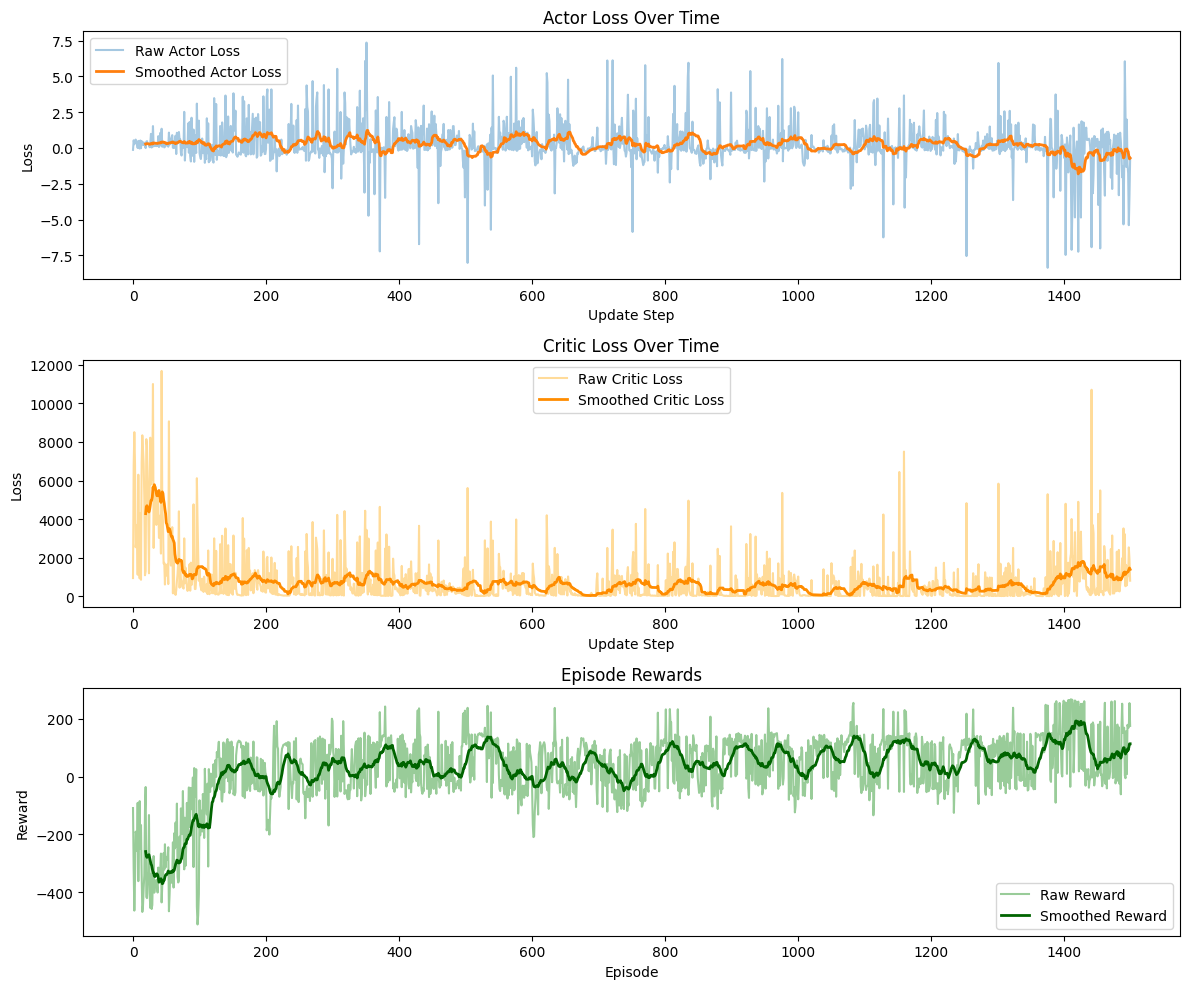

In [ ]:
def moving_average(data, window_size=20):
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_ppo_metrics(ppo, smooth_window=20):
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))

    # Actor Loss
    actor_raw = ppo.actor_loss_history
    actor_smoothed = moving_average(actor_raw, smooth_window)
    axes[0].plot(actor_raw, alpha=0.4, label='Raw Actor Loss')
    axes[0].plot(range(smooth_window-1, len(actor_raw)), actor_smoothed, label='Smoothed Actor Loss', linewidth=2)
    axes[0].set_title('Actor Loss Over Time')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Critic Loss
    critic_raw = ppo.critic_loss_history
    critic_smoothed = moving_average(critic_raw, smooth_window)
    axes[1].plot(critic_raw, alpha=0.4, label='Raw Critic Loss', color='orange')
    axes[1].plot(range(smooth_window-1, len(critic_raw)), critic_smoothed, label='Smoothed Critic Loss', color='darkorange', linewidth=2)
    axes[1].set_title('Critic Loss Over Time')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    # Episode Reward
    reward_raw = ppo.episode_rewards
    reward_smoothed = moving_average(reward_raw, smooth_window)
    axes[2].plot(reward_raw, alpha=0.4, label='Raw Reward', color='green')
    axes[2].plot(range(smooth_window-1, len(reward_raw)), reward_smoothed, label='Smoothed Reward', color='darkgreen', linewidth=2)
    axes[2].set_title('Episode Rewards')
    axes[2].set_xlabel('Episode')
    axes[2].set_ylabel('Reward')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

def mainTrain():
    env = gym.make('LunarLander-v3', render_mode=None)
    env.action_space.seed(42)
    env.observation_space.seed(42)

    agent = create_agent(env)
    ppo = PPO(agent)

    train(env, agent, ppo)
    plot_ppo_metrics(ppo)


if __name__ == "__main__":
    mainTrain()

DUELING DQN SETUP WITH VANILLA EXPERIENCE REPLAY AND EPSILON GREEDY (VANILLA DQN BASELINE)

BASELINE HYPER PARAMETERS

In [30]:
# BASELINE DQN HYPERPARAMETERS
HP = {
    'env_name': "LunarLander-v3",
    'hidden_dim': 256,
    'lr': 0.004,
    'grad_clip': 3,
    'epsilon_start': 1.0,
    'epsilon_min': 0.01,
    'epsilon_decay': 0.99725,
    'gamma': 0.99,
    'batch_size': 64,
    'buffer_size': 100000,
    'target_update_freq': 75,
    'episodes': 1500,
    'max_steps': 700,
    'use_per': False,
}


#### BASELINE DUELING DQN NEURAL NETWORK CLASS SETUP 

- `Feature extractor`: Two fully connected layers with ReLU activations that transform the input state into a feature representation
  - First layer: Transforms state features to hidden_dim (128) neurons
  - Second layer: Processes hidden_dim neurons to generate features

- `Value stream`: Two fully connected layers that estimate state value V(s)
  - Takes features from the feature extractor
  - Output is a single value representing how good the state is

- `Advantage stream`: Two fully connected layers that estimate advantages A(s,a)
  - Takes features from the feature extractor
  - Output has one value per possible action representing relative action advantage

- `Forward method`: 
  - Combines value and advantage streams using the following formula
  - Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))
  - Subtracting the mean advantage to help with stability

**USING A DUELING DQN ARCHITECTURE ALLOWS THE NETWORK TO LEARN STATE VALUES INDEPENDENTLY FROM ACTION ADVANTAGES, WHICH CAN IMPROVE LEARNING IN ENVIRONMENTS WHERE SOME STATES ARE VALUABLE REGARDLESS OF WHICH ACTION IS TAKEN**

In [31]:
class BaselineDuelingDQN(nn.Module):
    def __init__(self, input_dim, n_actions):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Linear(input_dim, HP['hidden_dim']),
            nn.ReLU(),
            nn.Linear(HP['hidden_dim'], HP['hidden_dim']),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(HP['hidden_dim'], HP['hidden_dim']),
            nn.ReLU(),
            nn.Linear(HP['hidden_dim'], 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(HP['hidden_dim'], HP['hidden_dim']),
            nn.ReLU(),
            nn.Linear(HP['hidden_dim'], n_actions)
        )

    def forward(self, x):
        x = x.float()
        features = self.feature(x)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean(dim=1, keepdim=True))
        return qvals

#### VANILLA EXPERIENCE REPLAY BUFFER

THE PURPOSE OF THE REPLAY BUFFER CLASS IS TO STORE AND RETRIEVE THE AGENT'S PAST EXPERIENCES:

**KEY COMPONENTS:**
- `Buffer storage`: Uses a deque with a fixed maximum length to automatically discard old experiences when capacity is reached

- `add function`: Adds a new transition (state, action, reward, next_state, done) to memory

- `sample function`: 
  - Randomly selects a batch of experiences
  - Converts the batch into numpy arrays for efficient processing
  - Separates the experiences into states, actions, rewards, next_states, and done flags
  - Returns properly formatted arrays for neural network training

- `len function`: Returns current buffer size, used to check if enough experiences are collected for training

**THIS EXPERIENCE REPLAY MECHANISM IS CRUCIAL BECAUSE OF THE FOLLOWING**:
1. Breaks correlations between consecutive experiences
2. Allows for multiple learning updates from a single experience
3. Helps the agent learn from both recent and older experiences

In [32]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)

## BASELINE DQN AGENT IMPLEMENTATION

THE BASELINEDQNAGENT CLASS IMPLEMENTS THE CORE REINFORCEMENT LEARNING ALGORITHM:

**INITIALIZATION COMPONENTS:**
- Creates policy and target networks with identical architecture
- Sets up Adam optimizer for network updates
- Initializes the replay buffer and exploration parameters

**KEY METHODS:**
- `act function`: 
  - Implements epsilon-greedy strategy
  - With probability epsilon: selects a random action (exploration)
  - Otherwise: selects the action with highest Q-value (exploitation)
  - Uses the policy network to estimate Q-values

- `update function`: 
  - Samples a batch of experiences from the replay buffer
  - Computes current Q-values using the policy network
  - Computes target Q-values using a combination of policy and target networks (Double DQN approach)
  - Calculates temporal difference (TD) loss between current and target values
  - Performs gradient descent to update the policy network
  - Uses gradient clipping to prevent large updates
  - Returns the loss value for monitoring

**THIS IMPLEMENTATION USES DOUBLE DQN TO REDUCE OVERESTIMATION BIAS BY USING THE POLICY NETWORK TO SELECT THE BEST ACTION BUT THE TARGET NETWORK TO EVALUATE ITS VALUE.**

In [33]:
class BaselineDQNAgent:
    def __init__(self, state_dim, action_dim):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.action_dim = action_dim
        
        self.policy_net = BaselineDuelingDQN(state_dim, action_dim).to(self.device)
        self.target_net = BaselineDuelingDQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=HP['lr'])

        self.buffer = ReplayBuffer(HP['buffer_size'])

        self.epsilon = HP['epsilon_start']
        self.epsilon_min = HP['epsilon_min']
        self.epsilon_decay = HP['epsilon_decay']

    def act(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_dim)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        return q_values.argmax().item()

    def update(self):
        if len(self.buffer) < HP['batch_size']:
            return 0

        s, a, r, s_next, done = self.buffer.sample(HP['batch_size'])

        s = torch.FloatTensor(s).to(self.device)
        a = torch.LongTensor(a).unsqueeze(1).to(self.device)
        r = torch.FloatTensor(r).unsqueeze(1).to(self.device)
        s_next = torch.FloatTensor(s_next).to(self.device)
        done = torch.FloatTensor(done).unsqueeze(1).to(self.device)

        q_values = self.policy_net(s).gather(1, a)
        with torch.no_grad():
            best_action = self.policy_net(s_next).argmax(dim=1, keepdim=True)
            next_q = self.target_net(s_next).gather(1, best_action)
            target = r + HP['gamma'] * next_q * (1 - done)

        loss = F.smooth_l1_loss(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), HP['grad_clip'])
        self.optimizer.step()

        return loss.item()

#### BASELINE DQN TRAINER CLASS 

THIS BASELINEDQNTRAINER CLASS SETS UP THE ENTIRE TRAINING PROCESS:

**INITIALIZATION COMPONENTS:**
- Creates the lunar lander environment and initializes the DQN agent
- Sets up tracking for metrics: scores, losses, epsilon values, and action distributions
- Captures a sample state for monitoring Q-value evolution throughout training

**KEY FUNCTIONS:**
- `set_seed`: Ensures reproducible results by fixing random number generation across all libraries

- `moving_avg`: Calculates moving averages for smoother visualization of noisy data

- `train function`: CONTAINS THE MAIN TRAINING LOOP
 - Fixes the random seed for reproducibility
    - **FOR EACH EPISODE**:
        - Resets the environment with a new seed for variety
        - Tracks episode reward, losses, and action frequency
    - **FOR EACH STEP IN THE EPISODE**:
        - Gets action from agent (random or predicted)
        - Executes action in environment
        - Stores experience in replay buffer
        - Updates agent's policy
        - Terminates if episode ends
 - Updates exploration rate (epsilon decay)
 - Periodically updates target network for stable learning
 - Records metrics for visualization
 - Saves best-performing model based on 100-episode average
 - Logs training progress including rewards and action distribution
 - Periodically checks Q-values on a sample state to track learning

**PERFORMANCE VISUALIZATION FUNCTION:**
- `plot_results`: Creates three detailed graphs:
 1. Episode rewards plot with moving average and best performance markers
 2. TD loss plot showing prediction accuracy improvements
 3. Dual-axis plot showing both epsilon decay and action selection patterns

**THIS CLASS HANDLES ALL TRAINING LOGISTICS, PERFORMANCE TRACKING, MODEL SAVING, AND RESULTS VISUALIZATION NEEDED TO UNDERSTAND THE DQN AGENT'S LEARNING PROGRESS.**

In [19]:
class BaselineDQNTrainer:
    def __init__(self):
        self.env = gym.make(HP['env_name'])
        self.agent = BaselineDQNAgent(
            self.env.observation_space.shape[0], 
            self.env.action_space.n,
            hidden_dim = 256
        )

        self.scores = []
        self.losses = []
        self.eps_history = []
        self.action_distributions = []
        self.best_avg = -np.inf
        self.sample_state, _ = self.env.reset(seed=42)

    def set_seed(self, seed=42):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def moving_avg(self, data, window=20):
        return np.convolve(data, np.ones(window)/window, mode='same')
    
    def test(self, model_path='best_dueling_dqn_lunarlander.pth', num_episodes=100, render=False):
    
        # Load the trained model
        self.agent.policy_net.load_state_dict(torch.load(model_path))
        self.agent.policy_net.eval()
        
        # Set exploration to minimum for testing (mostly exploitation)
        test_epsilon = 0.01
        
        rewards = []
        success_count = 0
        action_distribution = np.zeros(self.agent.action_dim)
        
        # Set up rendering if required
        render_mode = "human" if render else None
        if render:
            test_env = gym.make(HP['env_name'], render_mode=render_mode)
        else:
            test_env = gym.make(HP['env_name'])
        
        self.set_seed(42)  # Use same seed for reproducibility
        
        for episode in range(num_episodes):
            state, _ = test_env.reset(seed=42 + episode)
            episode_reward = 0
            steps = 0
            done = False
            episode_actions = np.zeros(self.agent.action_dim)
            
            while not done and steps < HP['max_steps']:
                # Use epsilon-greedy with minimal exploration
                if np.random.random() < test_epsilon:
                    action = np.random.randint(self.agent.action_dim)
                else:
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.agent.device)
                    with torch.no_grad():
                        q_values = self.agent.policy_net(state_tensor)
                        action = q_values.argmax().item()
                
                next_state, reward, terminated, truncated, _ = test_env.step(action)
                done = terminated or truncated
                
                episode_reward += reward
                episode_actions[action] += 1
                state = next_state
                steps += 1
            
            rewards.append(episode_reward)
            action_distribution += episode_actions
            
            # Count successful landings (reward > 200 is typically considered successful)
            if episode_reward > 200:
                success_count += 1
                
            print(f"Test Episode {episode+1}/{num_episodes} | Reward: {episode_reward:.1f} | Steps: {steps}")
        
        # Calculate statistics
        average_reward = np.mean(rewards)
        std_reward = np.std(rewards)
        success_rate = success_count / num_episodes * 100
        normalized_actions = action_distribution / action_distribution.sum()
        
        # Print summary
        print("\n=== Test Results ===")
        print(f"Average Reward: {average_reward:.1f} ± {std_reward:.1f}")
        print(f"Success Rate: {success_rate:.1f}%")
        print(f"Action Distribution: {normalized_actions}")
        
        # Plot histogram of rewards
        plt.figure(figsize=(10, 6))
        plt.hist(rewards, bins=20, alpha=0.7)
        plt.axvline(x=average_reward, color='red', linestyle='--', 
                    label=f'Mean: {average_reward:.1f}')
        plt.axvline(x=200, color='green', linestyle='-', 
                    label='Success Threshold (200)')
        plt.title("Test Reward Distribution")
        plt.xlabel("Episode Reward")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()
        
        return average_reward, success_rate
    def train(self):
        self.set_seed(42)
        with torch.no_grad():
            sample_q = self.agent.policy_net(
                torch.FloatTensor(self.sample_state).unsqueeze(0).to(self.agent.device)
            )
        print("Initial Q-values:", sample_q.detach().cpu().numpy())

        for episode in range(1, HP['episodes'] + 1):
            state, _ = self.env.reset(seed=42 + episode)
            episode_reward = 0
            episode_losses = []
            action_counts = np.zeros(self.agent.action_dim)

            for step in range(HP['max_steps']):
                action = self.agent.act(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                self.agent.buffer.add((state, action, reward, next_state, done))
                episode_reward += reward
                action_counts[action] += 1

                state = next_state
                loss = self.agent.update()
                if loss:
                    episode_losses.append(loss)

                if done:
                    break

            self.agent.decay_epsilon()

            if episode % HP['target_update_freq'] == 0:
                self.agent.target_net.load_state_dict(self.agent.policy_net.state_dict())

            avg_loss = np.mean(episode_losses) if episode_losses else 0.0
            self.losses.append(avg_loss)
            self.eps_history.append(self.agent.epsilon)
            self.scores.append(episode_reward)
            self.action_distributions.append(action_counts.copy())

            avg_score = np.mean(self.scores[-100:])
            if avg_score > self.best_avg:
                self.best_avg = avg_score
                torch.save(self.agent.policy_net.state_dict(), 'best_dueling_dqn_lunarlander.pth')

            if episode % 500 == 0:
                torch.save(self.agent.policy_net.state_dict(), f'lander_ep{episode}.pth')

            print(f"Episode {episode} | Reward: {episode_reward:.1f} | Avg: {avg_score:.1f} | Epsilon: {self.agent.epsilon:.3f} | Loss: {avg_loss:.4f}")
            print(f"Action dist: {action_counts.astype(int)}")

            if episode % 10 == 0:
                with torch.no_grad():
                    q_vals = self.agent.policy_net(
                        torch.FloatTensor(self.sample_state).unsqueeze(0).to(self.agent.device)
                    ).cpu().numpy().squeeze()
                print(f"Q-values (Ep {episode}): min={q_vals.min():.3f}, max={q_vals.max():.3f}, mean={q_vals.mean():.3f}")

        self.plot_results()

    def plot_results(self):
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        plt.plot(self.scores, alpha=0.3, label="Episode Reward")
        moving_avg_rewards = self.moving_avg(self.scores, 100)
        plt.plot(range(len(moving_avg_rewards)), moving_avg_rewards, color='blue', label="100-Episode Moving Avg")
        best_ep_idx = np.argmax(self.scores)
        best_ep_reward = self.scores[best_ep_idx]
        best_avg_reward = np.max([
            np.mean(self.scores[i:i + 100]) if i + 100 <= len(self.scores) else -np.inf
            for i in range(len(self.scores))
        ])
        plt.axhline(y=best_ep_reward, color='red', linestyle='--', label=f'Best Reward: {best_ep_reward:.1f}')
        plt.axvline(x=best_ep_idx, color='red', linestyle=':')
        plt.axhline(y=best_avg_reward, color='green', linestyle='--', label=f'Best Avg Reward: {best_avg_reward:.1f}')
        plt.title("Episode Rewards (Vanilla Deep Q-Network)")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(self.losses, alpha=0.3, label="Episode Loss")
        smoothed_losses = self.moving_avg(self.losses, 50)
        plt.plot(range(len(smoothed_losses)), smoothed_losses, color='orange', label="50-Episode Moving Avg")
        plt.title("TD Loss per Episode")
        plt.xlabel("Episode")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(self.eps_history, color='blue', label='Epsilon')
        plt.ylabel('Epsilon', color='blue')
        plt.tick_params(axis='y', labelcolor='blue')
        ax2 = plt.gca().twinx()
        action_percentages = np.array([
            dist / dist.sum() if dist.sum() > 0 else np.zeros_like(dist)
            for dist in self.action_distributions
        ])
        def smooth(data, window=20):
            return np.convolve(data, np.ones(window) / window, mode='same')
        for i in range(self.agent.action_dim):
            smoothed = smooth(action_percentages[:, i])
            ax2.plot(smoothed, alpha=0.8, label=f'Action {i}')
        ax2.set_ylabel('Action %')
        ax2.legend(loc='upper right')
        plt.title("Epsilon Decay & Action Selection")
        plt.xlabel("Episode")
        plt.tight_layout()
        plt.show()


MAIN IMPLEMENTATION OF BASELINE DUELING DQN

Initial Q-values: [[ 0.08407681 -0.02472903  0.03156963  0.15682209]]
Episode 1 | Reward: -97.1 | Avg: -97.1 | Epsilon: 0.997 | Loss: 0.6774
Action dist: [17 16 15 23]
Episode 2 | Reward: -399.0 | Avg: -248.1 | Epsilon: 0.995 | Loss: 1.0711
Action dist: [29 17 16 34]
Episode 3 | Reward: -106.2 | Avg: -200.8 | Epsilon: 0.992 | Loss: 0.3639
Action dist: [22 27 15 23]
Episode 4 | Reward: -211.8 | Avg: -203.5 | Epsilon: 0.989 | Loss: 0.4269
Action dist: [21  7 14 18]
Episode 5 | Reward: -361.2 | Avg: -235.1 | Epsilon: 0.986 | Loss: 0.6911
Action dist: [40 34 35 21]
Episode 6 | Reward: -130.3 | Avg: -217.6 | Epsilon: 0.984 | Loss: 0.9158
Action dist: [14 24 31 29]
Episode 7 | Reward: -168.1 | Avg: -210.5 | Epsilon: 0.981 | Loss: 0.7964
Action dist: [34 29 33 26]
Episode 8 | Reward: -120.3 | Avg: -199.3 | Epsilon: 0.978 | Loss: 0.9358
Action dist: [17 23 22 14]
Episode 9 | Reward: -141.9 | Avg: -192.9 | Epsilon: 0.976 | Loss: 0.7325
Action dist: [26 24 28 34]
Episode 10 | Reward: -196.6 | Av

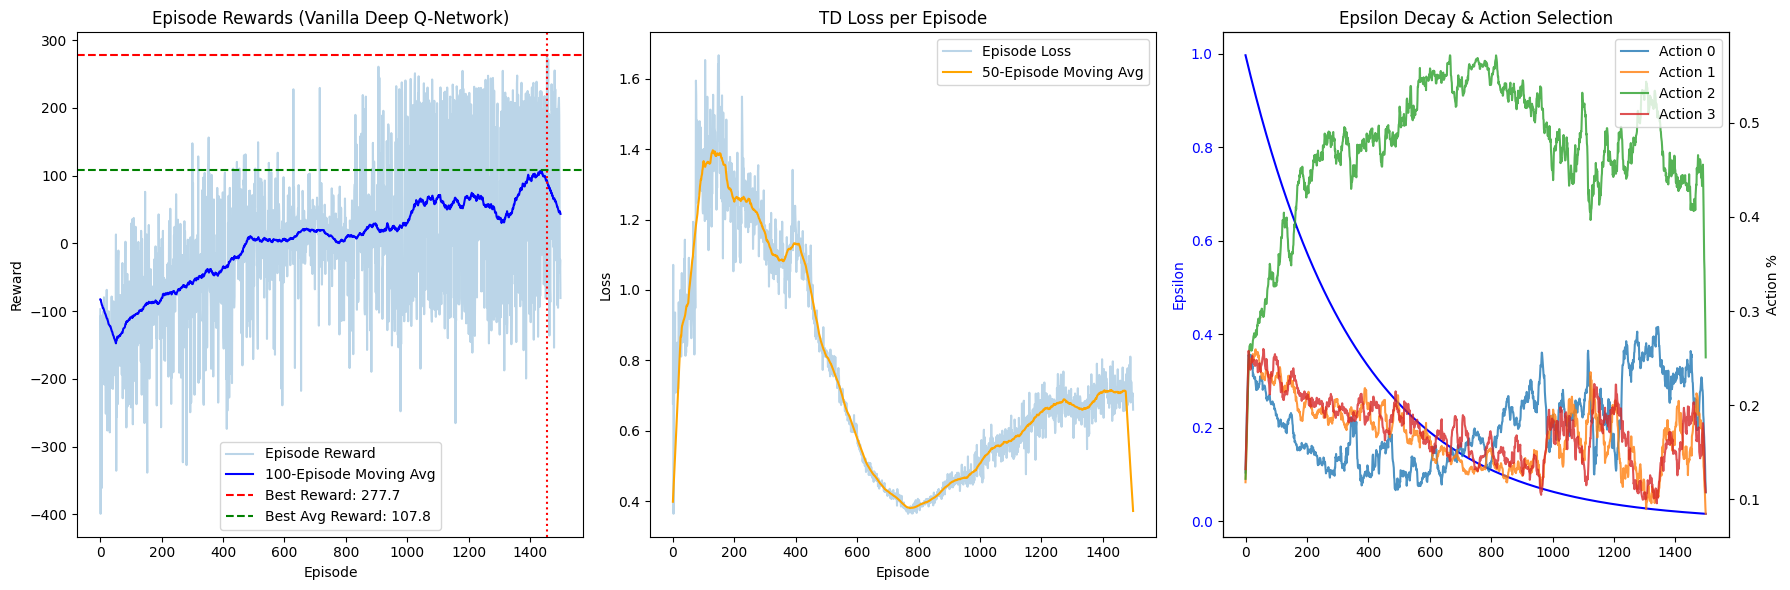

In [303]:
if __name__ == "__main__":
    trainer = BaselineDQNTrainer()
    trainer.train()

TEST OF BASELINE DQN MODEL

In [43]:
def test_model(model_path = 'best_dueling_dqn_lunarlander.pth', num_episodes=20, render=False):
    
    # Check if file exists
    if not os.path.exists(model_path):
        print(f"Error: Model file '{model_path}' not found")
        return 0.0, 0.0
    
    try:
        # Load model to examine architecture
        state_dict = torch.load(model_path)
        
        # Create test environment
        env_name = "LunarLander-v3"
        test_env = gym.make(env_name, render_mode="human" if render else None)
        
        # Get input/output dimensions
        input_dim = test_env.observation_space.shape[0]
        output_dim = test_env.action_space.n
        
        # Extract architecture info from the state dict
        hidden_dim = state_dict['feature.0.weight'].shape[0]
        value_hidden = state_dict['value_stream.0.weight'].shape[0]
        advantage_hidden = state_dict['advantage_stream.0.weight'].shape[0]
        
        print(f"Detected model architecture:")
        print(f"- Input dimension: {input_dim}")
        print(f"- Output dimension: {output_dim}")
        print(f"- Feature hidden dimension: {hidden_dim}")
        print(f"- Value stream hidden: {value_hidden}")
        print(f"- Advantage stream hidden: {advantage_hidden}")
                
        class TestDuelingDQN(torch.nn.Module):
            def __init__(self):
                super().__init__()
                
                # Feature layer
                self.feature = torch.nn.Sequential(
                    torch.nn.Linear(input_dim, hidden_dim),
                    torch.nn.ReLU(),
                    torch.nn.Linear(hidden_dim, hidden_dim),
                    torch.nn.ReLU()
                )
                
                # Value stream
                self.value_stream = torch.nn.Sequential(
                    torch.nn.Linear(hidden_dim, value_hidden),
                    torch.nn.ReLU(),
                    torch.nn.Linear(value_hidden, 1)
                )
                
                # Advantage stream
                self.advantage_stream = torch.nn.Sequential(
                    torch.nn.Linear(hidden_dim, advantage_hidden),
                    torch.nn.ReLU(),
                    torch.nn.Linear(advantage_hidden, output_dim)
                )
                
            def forward(self, x):
                features = self.feature(x)
                values = self.value_stream(features)
                advantages = self.advantage_stream(features)
                return values + (advantages - advantages.mean(dim=1, keepdim=True))
        
        # Create network with exact architecture
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        policy_net = TestDuelingDQN().to(device)
        
        # Load the state dict
        policy_net.load_state_dict(state_dict)
        policy_net.eval()
        
        # Set seeds for reproducibility
        random.seed(42)
        np.random.seed(42)
        torch.manual_seed(42)
        
        # Test settings - No exploration during testing
        rewards = []
        success_count = 0
        max_steps = 1000  
        
        for episode in range(num_episodes):
            state, _ = test_env.reset(seed=42 + episode)
            episode_reward = 0
            steps = 0
            done = False
            
            while not done and steps < max_steps:
                # Pure exploitation - always choose best action
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                with torch.no_grad():
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax().item()
                
                next_state, reward, terminated, truncated, _ = test_env.step(action)
                done = terminated or truncated
                
                episode_reward += reward
                state = next_state
                steps += 1
            
            rewards.append(episode_reward)
            
            if episode_reward > 200:
                success_count += 1
                
            print(f"Test Episode {episode+1}/{num_episodes} | Reward: {episode_reward:.1f} | Steps: {steps}")
        
        # Calculate statistics
        average_reward = np.mean(rewards)
        std_reward = np.std(rewards)
        success_rate = success_count / num_episodes * 100
        
        # Print summary
        print("\n=== Test Results ===")
        print(f"Average Reward: {average_reward:.1f} ± {std_reward:.1f}")
        print(f"Success Rate: {success_rate:.1f}%")
        
        return average_reward, success_rate
        
    except Exception as e:
        print(f"Error testing model: {str(e)}")
        import traceback
        traceback.print_exc()
        return 0.0, 0.0

# Test Function Implementation
average_reward, success_rate = test_model('best_dueling_dqn_lunarlander.pth', num_episodes=100, render=False)

Detected model architecture:
- Input dimension: 8
- Output dimension: 4
- Feature hidden dimension: 256
- Value stream hidden: 128
- Advantage stream hidden: 128
Test Episode 1/100 | Reward: 106.8 | Steps: 1000
Test Episode 2/100 | Reward: 193.7 | Steps: 277
Test Episode 3/100 | Reward: 254.7 | Steps: 468
Test Episode 4/100 | Reward: 213.5 | Steps: 604
Test Episode 5/100 | Reward: 265.2 | Steps: 262
Test Episode 6/100 | Reward: 121.5 | Steps: 1000
Test Episode 7/100 | Reward: 202.9 | Steps: 377
Test Episode 8/100 | Reward: 225.1 | Steps: 485
Test Episode 9/100 | Reward: 220.9 | Steps: 580
Test Episode 10/100 | Reward: 28.4 | Steps: 1000
Test Episode 11/100 | Reward: 259.0 | Steps: 308
Test Episode 12/100 | Reward: 103.5 | Steps: 1000
Test Episode 13/100 | Reward: 237.9 | Steps: 277
Test Episode 14/100 | Reward: 225.9 | Steps: 403
Test Episode 15/100 | Reward: 276.1 | Steps: 333
Test Episode 16/100 | Reward: 254.8 | Steps: 496
Test Episode 17/100 | Reward: 261.5 | Steps: 364
Test Episod

# III. Methods

## III.A Experience Replay

- Explain your choice of ER (other than vanilla ER)
- Explain your codes.

DUELING DQN WITH PRIORITIZED EXPERIENCE REPLAY (PER) AND EPSILON GREEDY

PRIORITIZED EXPERIENCE REPLAY MODEL HYPERPARAMETERS

In [ ]:
# PER HYPERPARAMETERS
PHP = {
    # Environment
    'env_name': "LunarLander-v3",
    
    # Network
    'hidden_dim': 256,
    'lr': 0.002,
    'grad_clip': 1,
        
    # Exploration - Fixed epsilon parameters
    'epsilon_start': 1.0,  # Changed from 'epsilon_start'
    'epsilon_min': 0.01,      # Changed from 'epsilon_min'
    'epsilon_decay': 0.9975,   # Added decay rate
    
    # Training
    'gamma': 0.99,
    'batch_size': 128,
    'buffer_size': 100000,
    'target_update_freq': 50,
    'episodes': 1500,
    'max_steps': 1000,
    
    # Prioritized Replay Buffer
    'use_per': True,
    'per_alpha': 0.5,
    'per_beta_start': 0.4,
    'per_beta_frames': 150000,
    'per_epsilon': 0.15,
}

**DEFINING EPSILON-GREEDY EXPLORATION AND DECAY FUNCTION (MOVES FROM ALL EXPLORATION ---> TO ALMOST ALL EXPLOITATION)**

In [313]:
def epsilon_greedy(state, n_actions, policy_net, device):
    
    if np.random.uniform() < PHP['epsilon']:  
        # Exploration: Choose random action
        action = np.random.randint(n_actions)
    else:
        device = next(policy_net.parameters()).device
        # Exploitation: Choose action with highest Q-value
        state_tensor = torch.tensor(np.expand_dims(state, 0), dtype=torch.float32).to(device)
        with torch.no_grad():
            q_values = policy_net(state_tensor)  # Get Q-values from the policy network
        action = q_values.argmax().item()  # Select action with the highest Q-value
    
    return action  # Return the selected action

def epsilon_decay(episodes=1500):
    return np.exp(np.log(PHP['min_epsilon'] / PHP['initial_epsilon']) / episodes)

#### PRIORITIZED EXPERIENCE REPLAY MODEL DUELING DQN NEURAL NETWORK CLASS SETUP 

- `Feature extractor`: Two fully connected layers with ReLU activations that transform the input state into a feature representation
  - First layer: Transforms state features to hidden_dim (128) neurons
  - Second layer: Processes hidden_dim neurons to generate features

- `Value stream`: Two fully connected layers that estimate state value V(s)
  - Takes features from the feature extractor
  - Output is a single value representing how good the state is

- `Advantage stream`: Two fully connected layers that estimate advantages A(s,a)
  - Takes features from the feature extractor
  - Output has one value per possible action representing relative action advantage

- `Forward method`: 
  - Combines value and advantage streams using the following formula
  - Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))
  - Subtracting the mean advantage to help with stability

**USING A DUELING DQN ARCHITECTURE ALLOWS THE NETWORK TO LEARN STATE VALUES INDEPENDENTLY FROM ACTION ADVANTAGES, WHICH CAN IMPROVE LEARNING IN ENVIRONMENTS WHERE SOME STATES ARE VALUABLE REGARDLESS OF WHICH ACTION IS TAKEN**

In [ ]:
class PERDuelingDQN(nn.Module):
    def __init__(self, input_dim, n_actions):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Linear(input_dim, PHP['hidden_dim']),
            nn.ReLU(),
            nn.Linear(PHP['hidden_dim'], PHP['hidden_dim']),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(PHP['hidden_dim'], PHP['hidden_dim']//2),
            nn.ReLU(),
            nn.Linear(PHP['hidden_dim']//2, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(PHP['hidden_dim'], PHP['hidden_dim']//2),
            nn.ReLU(),
            nn.Linear(PHP['hidden_dim']//2, n_actions)
        )

    def forward(self, x):
        x = x.float()
        features = self.feature(x)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean(dim=1, keepdim=True))
        return qvals

#### SUMTREE DATA STRUCTURE

THE SUMTREE IS A SPECIALIZED BINARY TREE THAT ENABLES EFFICIENT PRIORITIZED SAMPLING.

**STRUCTURE AND PROPERTIES:**
- Leaf nodes: Store experiences alongside their priorities
- Internal nodes: Contain the sum of all child node priorities
- Root node: Holds the total priority sum of all experiences

**KEY OPERATIONS:**
- `add`: Inserts a new experience with its priority
- `update`: Modifies an experience's priority and propagates changes upward
- `get`: Samples an experience based on its priority weighting

**IMPORTANCE FOR PRIORITIZED EXPERIENCE REPLAY:**
- Allows sampling proportional to priority without iterating through entire buffer
- Enables fast updates when priorities change after learning
- Makes prioritized experience replay computationally feasible for real-time learning
- Transforms sampling from O(n) to O(log n) operation

**PRIORITIZED EXPERIENCE REPLAY IS MADE PRACTICABLE BY USING SUM TREE’S EFFICIENT DATA STRUCTURE**

In [315]:
# SumTree for Prioritized Experience Replay (PER)
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.write = 0
        self.n_entries = 0

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2
        self.tree[parent] += change
        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = int((self.write % self.capacity) + self.capacity - 1)
        self.data[self.write] = data
        self.update(idx, float(p))
        self.write = (self.write + 1) % self.capacity
        if self.n_entries < self.capacity:
            self.n_entries += 1

    def update(self, idx, p):
        change = p - self.tree[idx]
        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1
        return idx, self.tree[idx], self.data[data_idx]

#### PRIORITIZED REPLAY BUFFER

**PRIORITIZED EXPERIENCE REPLAY ENHANCES RL AGENT LEARNING BY FOCUSING ON IMPORTANT EXPERIENCES.**

**`BENEFITS OF PER/WHY I DECIDED TO USE IT`:**
- Focuses training on the most informative experiences (high TD error)
- Revisits surprising or rare events more frequently
- Learns more efficiently from the same amount of experience
- Addresses the uniform sampling inefficiency of standard experience replay

**DATA STRUCTURE:**
- Uses SumTree to store experiences with their priorities
- Maintains alpha parameter that determines prioritization strength
- Tracks beta parameter for importance sampling correction

**KEY FUNCTIONS:**
- `__init__`: 
        - Initializes SumTree with specified capacity
        - Sets initial prioritization parameters (alpha, beta, epsilon)
        - Configures beta increment for gradual annealing

- `add function`: 
        - Adds new transitions to memory with maximum priority
        - Ensures new experiences are sampled at least once
        - Uses alpha parameter to control degree of prioritization

- `sample function`: 
        - Selects batch of experiences based on their priorities
        - Divides priority sum into segments for uniform segment sampling
        - Calculates importance sampling weights using beta parameter
        - Returns experiences plus sampling indices and weights for update

- `update_priorities function`: 
        - Updates priorities based on latest TD errors
        - Applies minimum priority (epsilon) to ensure exploration
        - Converts absolute TD errors to priorities using alpha exponent
        - Increases beta parameter to reduce correction as training progresses

**PRIORITIZED REPLAY TYPICALLY LEADS TO FASTER LEARNING AND BETTER FINAL PERFORMANCE COMPARED TO VANILLA EXPERIENCE REPLAY.**

In [316]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        self.alpha = PHP['per_alpha']
        self.beta = PHP['per_beta_start']
        self.beta_increment = (1.0 - PHP['per_beta_start']) / PHP['per_beta_frames']
        self.epsilon = PHP['per_epsilon']
        self.max_priority = 1.0
        self.capacity = capacity

    def add(self, transition):
        priority = self.max_priority ** self.alpha
        self.tree.add(priority, transition)

    def sample(self, batch_size):
        batch = []
        idxs = []
        priorities = []
        segment = self.tree.total() / batch_size

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = np.random.uniform(a, b)
            idx, p, data = self.tree.get(s)
            batch.append(data)
            idxs.append(idx)
            priorities.append(p)

        sampling_probs = np.array(priorities) / self.tree.total()
        is_weights = np.power(self.capacity * sampling_probs, -self.beta)
        is_weights /= is_weights.max()

        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32),
            idxs,
            is_weights
        )

    def update_priorities(self, idxs, priorities):
        priorities = np.abs(priorities) + self.epsilon
        for idx, priority in zip(idxs, priorities):
            clipped_priority = float(np.clip(priority, 1e-2, self.max_priority))
            p = clipped_priority ** self.alpha
            self.tree.update(idx, p)
            self.max_priority = max(float(self.max_priority), float(priority))
        self.beta = min(1.0, self.beta + self.beta_increment)

PRIORITIZED EXPERIENCE REPLAY MODEL DQN AGENT

#### PRIORITIZED EXPERIENCE REPLAY DQN AGENT IMPLEMENTATION

THE PERDQNAGENT CLASS COMBINES PRIORITIZED EXPERIENCE REPLAY WITH DUELING DQN:

**INITIALIZATION COMPONENTS:**
- Sets up policy and target dueling networks on appropriate device (GPU/CPU)
- Initializes Adam optimizer for network updates
- Creates prioritized replay buffer for storing important experiences
- Configures epsilon parameters with adaptive decay calculation

**KEY METHODS:**
- `act function`:
  - Implements epsilon-greedy action selection
  - With probability epsilon: selects random action (exploration)
  - Otherwise: selects highest Q-value action from policy network (exploitation)

- `decay_epsilon function`:
  - Reduces exploration rate according to exponential decay schedule
  - Maintains minimum exploration threshold

- `update function`:
  - Samples batch of experiences with importance weights from prioritized buffer
  - Computes current Q-values using policy network
  - Calculates target Q-values using Double DQN approach
  - Applies weighted Huber loss based on importance sampling
  - Updates network via gradient descent with clipping
  - Refreshes experience priorities based on new TD errors
  - Returns loss value for tracking

**THIS MODEL COMBINES MULTIPLE TECHNIQUES:** 
1. `PRIORITIZED REPLAY` TO FOCUS ON IMPORTANT EXPERIENCES
2. `DUELING DQN` TO SEPARATE STATE VALUES FROM ACTION ADVANTAGES
3. `DOUBLE DQN` TO REDUCE OVERESTIMATION BIAS.

In [317]:
class PERDQNAgent:
    def __init__(self, state_dim, action_dim):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.action_dim = action_dim
        
        self.policy_net = PERDuelingDQN(state_dim, action_dim).to(self.device)
        self.target_net = PERDuelingDQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=PHP['lr'])
        
        self.buffer = PrioritizedReplayBuffer(PHP['buffer_size'])
        
        # Epsilon management
        self.epsilon = PHP['epsilon_start']
        self.epsilon_min = PHP['epsilon_min']
        if PHP['epsilon_decay'] is None:
            # Calculate decay rate to reach epsilon_min over 80% of episodes
            self.epsilon_decay = np.exp(np.log(self.epsilon_min / self.epsilon) / (0.8 * PHP['episodes']))
        else:
            self.epsilon_decay = PHP['epsilon_decay']

    def act(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_dim)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
            return q_values.argmax().item()
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def update(self):
        if self.buffer.tree.n_entries < PHP['batch_size']:
            return 0
            
        s, a, r, s_next, done, idxs, weights = self.buffer.sample(PHP['batch_size'])
        
        s = torch.FloatTensor(s).to(self.device)
        a = torch.LongTensor(a).unsqueeze(1).to(self.device)
        r = torch.FloatTensor(r).unsqueeze(1).to(self.device)
        s_next = torch.FloatTensor(s_next).to(self.device)
        done = torch.FloatTensor(done).unsqueeze(1).to(self.device)
        weights = torch.FloatTensor(weights).unsqueeze(1).to(self.device)
        
        q_values = self.policy_net(s).gather(1, a)
        
        with torch.no_grad():
            best_action = self.policy_net(s_next).argmax(dim=1, keepdim=True)
            next_q = self.target_net(s_next).gather(1, best_action)
            target = r + PHP['gamma'] * next_q * (1 - done)
        
        td_errors = q_values - target
        loss = (F.smooth_l1_loss(q_values, target, reduction='none') * weights).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), PHP['grad_clip'])
        self.optimizer.step()
        
        self.buffer.update_priorities(idxs, td_errors.detach().cpu().numpy().squeeze())
        
        return loss.item()

PRIORITIZED EXPERIENCE REPLAY MODEL DQN TRAINER

#### PRIORITIZED EXPERIENCE REPLAY DQN TRAINER IMPLEMENTATION

PERDQNTRAINER CLASS CONTAINS THE COMPLETE TRAINING LOOP AND PLOTS FOR PERFORMANCE ANALAYSIS OF THE PERDQNAGENT:

**INITIALIZATION COMPONENTS:**
- Creates LunarLander-v3 environment
- Initializes the PERDQNAgent with correct state and action dimensions
- Sets up tracking for various training metrics (scores, losses, epsilon history, action distributions) so they can be plotted
- Stores reference state for Q-value monitoring

**KEY METHODS:**
- `set_seed function`:
    - Ensures reproducibility by fixing all random number generators
    - Controls randomness in Python, NumPy, PyTorch, and CUDA operations

- `moving_avg function`:
    - Applies window-based convolution smoothing to time-series data
    - Used for clearer visualization of training trends

- `train function`:
    - Executes full training loop across configured episodes
    - Manages environment reset and interaction for each episode
    - Collects experiences and triggers agent updates
    - Periodically synchronizes target network with policy network
    - Tracks and reports performance metrics
    - Saves best-performing model based on 100-episode average reward
    - Monitors Q-value statistics throughout training

- `plot_results function`:
 - Creates comprehensive visualization dashboard with three plots:
   1. Rewards with moving average and best performance markers
   2. TD losses with smoothed trend line
   3. Epsilon decay curve with action distribution percentages

**THIS IMPLEMENTATION PROVIDES COMPLETE TRAINING INFRASTRUCTURE WITH DETAILED TRACKING, VISUALIZATION, AND MODEL CHECKPOINTING TO MONITOR THE PERFORMANCE OF THE PERDQNAGENT.**

In [318]:
class PERDQNTrainer:
    def __init__(self):
        self.env = gym.make(PHP['env_name'])
        self.agent = PERDQNAgent(
            self.env.observation_space.shape[0], 
            self.env.action_space.n
        )

        # Training metrics
        self.scores = []
        self.losses = []
        self.eps_history = []
        self.action_distributions = []
        self.best_avg = -np.inf
        self.sample_state, _ = self.env.reset(seed=42)

    def set_seed(self, seed=42):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def moving_avg(self, data, window=20):
        return np.convolve(data, np.ones(window)/window, mode='same')

    def train(self):
        self.set_seed(42)
        
        # Initial Q-values
        with torch.no_grad():
            sample_q = self.agent.policy_net(
                torch.FloatTensor(self.sample_state).unsqueeze(0).to(self.agent.device)
            )
        print("Initial Q-values:", sample_q.detach().cpu().numpy())

        for episode in range(1, PHP['episodes'] + 1):
            state, _ = self.env.reset(seed=42 + episode)
            episode_reward = 0
            episode_losses = []
            action_counts = np.zeros(self.agent.action_dim)

            for step in range(PHP['max_steps']):
                action = self.agent.act(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                self.agent.buffer.add((state, action, reward, next_state, done))
                episode_reward += reward
                action_counts[action] += 1

                state = next_state
                loss = self.agent.update()
                if loss:
                    episode_losses.append(loss)

                if done:
                    break

            self.agent.decay_epsilon()

            if episode % PHP['target_update_freq'] == 0:
                self.agent.target_net.load_state_dict(self.agent.policy_net.state_dict())

            # Record metrics
            avg_loss = np.mean(episode_losses) if episode_losses else 0.0
            self.losses.append(avg_loss)
            self.eps_history.append(self.agent.epsilon)
            self.scores.append(episode_reward)
            self.action_distributions.append(action_counts.copy())

            avg_score = np.mean(self.scores[-100:])
            if avg_score > self.best_avg:
                self.best_avg = avg_score
                torch.save(self.agent.policy_net.state_dict(), 'best_dueling_dqn_lunarlander.pth')

            if episode % 500 == 0:
                torch.save(self.agent.policy_net.state_dict(), f'lander_ep{episode}.pth')

            # Print training progress
            print(f"Episode {episode} | Reward: {episode_reward:.1f} | "
                  f"Avg: {avg_score:.1f} | Epsilon: {self.agent.epsilon:.3f} | "
                  f"Loss: {avg_loss:.4f}")
            print(f"Action dist: {action_counts.astype(int)}")

            # Q-value diagnostics
            if episode % 10 == 0:
                with torch.no_grad():
                    q_vals = self.agent.policy_net(
                        torch.FloatTensor(self.sample_state).unsqueeze(0).to(self.agent.device)
                    ).cpu().numpy().squeeze()
                print(f"Q-values (Ep {episode}): min={q_vals.min():.3f}, "
                      f"max={q_vals.max():.3f}, mean={q_vals.mean():.3f}")

        self.plot_results()

    def plot_results(self):
        """Comprehensive training plots for epsilon-greedy exploration"""
        plt.figure(figsize=(18, 6))

        # --- 1. Reward Plot ---
        plt.subplot(1, 3, 1)
        plt.plot(self.scores, alpha=0.3, label="Episode Reward")
        moving_avg_rewards = self.moving_avg(self.scores, 100)
        plt.plot(range(len(moving_avg_rewards)), moving_avg_rewards,
                color='blue', label="100-Episode Moving Avg")

        # Mark best rewards
        best_ep_idx = np.argmax(self.scores)
        best_ep_reward = self.scores[best_ep_idx]
        best_avg_reward = np.max([
            np.mean(self.scores[i:i + 100]) if i + 100 <= len(self.scores) else -np.inf
            for i in range(len(self.scores))
        ])

        plt.axhline(y=best_ep_reward, color='red', linestyle='--',
                    label=f'Best Reward: {best_ep_reward:.1f}')
        plt.axvline(x=best_ep_idx, color='red', linestyle=':')

        plt.axhline(y=best_avg_reward, color='green', linestyle='--',
                    label=f'Best Avg Reward: {best_avg_reward:.1f}')

        plt.title("Episode Rewards (Epsilon-Greedy with Prioritized Experience Replay)")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.legend()

        # --- 2. Loss Plot ---
        plt.subplot(1, 3, 2)
        plt.plot(self.losses, alpha=0.3, label="Episode Loss")
        smoothed_losses = self.moving_avg(self.losses, 50)
        plt.plot(range(len(smoothed_losses)), smoothed_losses,
                color='orange', label="50-Episode Moving Avg")
        plt.title("TD Loss per Episode")
        plt.xlabel("Episode")
        plt.ylabel("Loss")
        plt.legend()

        # --- 3. Epsilon Decay & Smoothed Action Selection ---
        plt.subplot(1, 3, 3)
        plt.plot(self.eps_history, color='blue', label='Epsilon')
        plt.ylabel('Epsilon', color='blue')
        plt.tick_params(axis='y', labelcolor='blue')

        ax2 = plt.gca().twinx()
        action_percentages = np.array([
            dist / dist.sum() if dist.sum() > 0 else np.zeros_like(dist)
            for dist in self.action_distributions
        ])

        def smooth(data, window=20):
            return np.convolve(data, np.ones(window) / window, mode='same')

        for i in range(self.agent.action_dim):
            smoothed = smooth(action_percentages[:, i])
            ax2.plot(smoothed, alpha=0.8, label=f'Action {i}')
        ax2.set_ylabel('Action %')
        ax2.legend(loc='upper right')

        plt.title("Epsilon Decay & Action Selection")
        plt.xlabel("Episode")
        plt.tight_layout()
        plt.show()

MAIN IMPLEMENTATION OF PRIORITIZED EXPERIENCE REPLAY MODEL

Initial Q-values: [[-0.12965372 -0.09643511 -0.10938083  0.08688692]]
Episode 1 | Reward: -97.1 | Avg: -97.1 | Epsilon: 0.998 | Loss: 0.0000
Action dist: [17 16 15 23]
Episode 2 | Reward: -391.5 | Avg: -244.3 | Epsilon: 0.995 | Loss: 2.1056
Action dist: [24 24 19 32]
Episode 3 | Reward: -93.3 | Avg: -194.0 | Epsilon: 0.993 | Loss: 0.8330
Action dist: [21 27 21 22]
Episode 4 | Reward: -73.0 | Avg: -163.8 | Epsilon: 0.990 | Loss: 0.6002
Action dist: [11 16 16 17]
Episode 5 | Reward: -525.7 | Avg: -236.1 | Epsilon: 0.988 | Loss: 1.3883
Action dist: [32 32 35 31]
Episode 6 | Reward: -109.6 | Avg: -215.0 | Epsilon: 0.985 | Loss: 1.4247
Action dist: [22 22 30 21]
Episode 7 | Reward: -117.5 | Avg: -201.1 | Epsilon: 0.983 | Loss: 1.2265
Action dist: [24 26 13 29]
Episode 8 | Reward: -99.3 | Avg: -188.4 | Epsilon: 0.980 | Loss: 0.7947
Action dist: [20 21 26 15]
Episode 9 | Reward: -366.1 | Avg: -208.1 | Epsilon: 0.978 | Loss: 1.0661
Action dist: [27 32 17 18]
Episode 10 | Reward: -88.0 | Avg: -

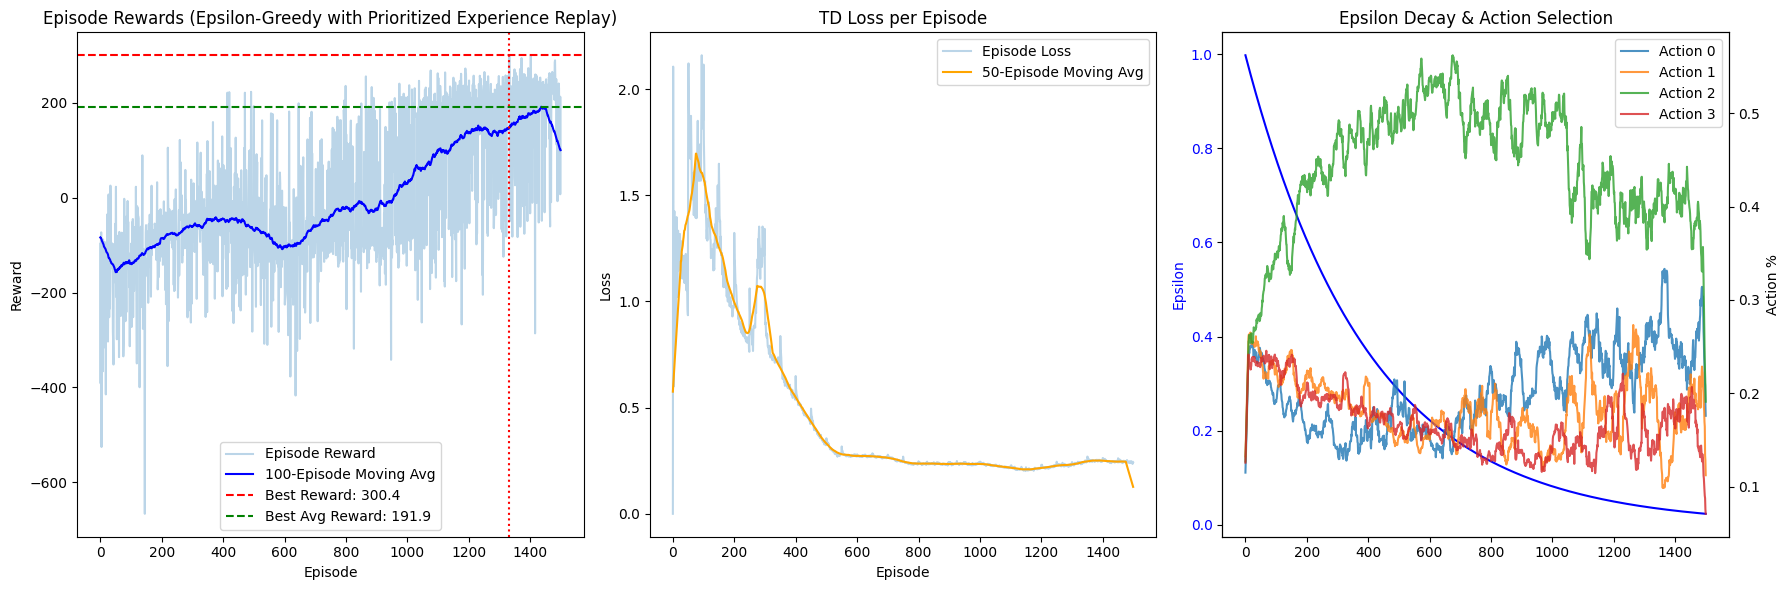

In [319]:
if __name__ == "__main__":
    trainer = PERDQNTrainer()
    trainer.train()

## III.A Exploration

- Explain your choice of exploration (other than classical exploration such as $\epsilon$-greedy or UCB)
- Explain your codes.

#### DUELING DQN WITH VANILLA EXPERIENCE REPLAY AND BOLTZMANN EXPLORATION

**I DECIDED TO USE BOLTZMANN AS MY ALTERNATIVE EXPLORATION METHOD FOR TWO MAIN REASONS:**
- `Balanced Exploration and Exploitation`: Boltzmann exploration selects actions based on probabilities derived from Q-values, effectively balancing the exploration of new actions and the exploitation of known rewarding actions.

- `Adaptive Behavior`: Unlike epsilon-greedy methods, boltzmann adapts exploration dynamically and as a result makes the exploration more intelligent and responsive to the agent’s current knowledge.

BOLTZMAN MODEL HYPERPARAMETERS

In [ ]:
# Boltzmann Hyperparameters
BHP = {
    # Environment
    'environment_name': "LunarLander-v3",
    
    # Network Architecture
    'hidden_layer_dimensions': 256,
    'learning_rate': 0.0005,
    'gradient_clip_value': 5,
        
    # Boltzmann Exploration
    'initial_temperature': 1.4,
    'minimum_temperature': 0.1,
    'temperature_decay_rate': 0.997,  # Multiplicative decay per episode
    
    # Training
    'gamma': 0.99,
    'batch_size': 128,
    'replay_buffer_size': 100000,
    'target_network_update_frequency': 50,
    'total_episodes': 1500,
    'maximum_steps_per_episode': 1000,
}

#### BOLTZMANN EXPLORATION MODEL DUELING DQN NEURAL NETWORK CLASS SETUP 

- `Feature extractor`: Two fully connected layers with ReLU activations that transform the input state into a feature representation
  - First layer: Transforms state features to hidden_dim (128) neurons
  - Second layer: Processes hidden_dim neurons to generate features

- `Value stream`: Two fully connected layers that estimate state value V(s)
  - Takes features from the feature extractor
  - Output is a single value representing how good the state is

- `Advantage stream`: Two fully connected layers that estimate advantages A(s,a)
  - Takes features from the feature extractor
  - Output has one value per possible action representing relative action advantage

- `Forward method`: 
  - Combines value and advantage streams using the following formula
  - Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))
  - Subtracting the mean advantage to help with stability

**USING A DUELING DQN ARCHITECTURE ALLOWS THE NETWORK TO LEARN STATE VALUES INDEPENDENTLY FROM ACTION ADVANTAGES, WHICH CAN IMPROVE LEARNING IN ENVIRONMENTS WHERE SOME STATES ARE VALUABLE REGARDLESS OF WHICH ACTION IS TAKEN**

In [328]:
class BoltDuelingDQN(nn.Module):
    def __init__(self, input_dimension, number_of_actions):
        super().__init__()
        self.feature_layer = nn.Sequential(
            nn.Linear(input_dimension, BHP['hidden_layer_dimensions']),
            nn.ReLU(),
            nn.Linear(BHP['hidden_layer_dimensions'], BHP['hidden_layer_dimensions']),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(BHP['hidden_layer_dimensions'], BHP['hidden_layer_dimensions']//2),
            nn.ReLU(),
            nn.Linear(BHP['hidden_layer_dimensions']//2, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(BHP['hidden_layer_dimensions'], BHP['hidden_layer_dimensions']//2),
            nn.ReLU(),
            nn.Linear(BHP['hidden_layer_dimensions']//2, number_of_actions)
        )

    def forward(self, state):
        state = state.float()
        features = self.feature_layer(state)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_values = values + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values



#### VANILLA EXPERIENCE REPLAY BUFFER

THE PURPOSE OF THE REPLAY BUFFER CLASS IS TO STORE AND RETRIEVE THE AGENT'S PAST EXPERIENCES:

**KEY COMPONENTS:**
- `Buffer storage`: Uses a deque with a fixed maximum length to automatically discard old experiences when capacity is reached

- `add function`: Adds a new transition (state, action, reward, next_state, done) to memory

- `sample function`: 
  - Randomly selects a batch of experiences
  - Converts the batch into numpy arrays for efficient processing
  - Separates the experiences into states, actions, rewards, next_states, and done flags
  - Returns properly formatted arrays for neural network training

- `len function`: Returns current buffer size, used to check if enough experiences are collected for training

**THIS EXPERIENCE REPLAY MECHANISM IS CRUCIAL BECAUSE OF THE FOLLOWING**:
1. Breaks correlations between consecutive experiences
2. Allows for multiple learning updates from a single experience
3. Helps the agent learn from both recent and older experiences

In [ ]:
class ExperienceReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)
    
    def add_experience(self, experience):
        self.buffer.append(experience)
    
    def sample_batch(self, batch_size):
        if len(self.buffer) < batch_size:
            return None
        
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32)
        )

#### BOLTZMANN TEMPERATURE DQN AGENT

**THE BOLTDQNAGENT CLASS IMPLEMENTS DUELING DQN MODEL USING BOLTZMANN EXPLORATION INSTEAD OF EPSILON-GREEDY EXPLORATION.**

**INITIALIZATION COMPONENTS:**
- Sets up policy and target dueling networks on appropriate device (GPU/CPU)
- Initializes Adam optimizer for network updates
- Creates experience replay buffer for storing transitions
- Configures temperature parameters for Boltzmann exploration

**KEY METHODS:**
- `boltzmann_exploration function`:
    - Implements probabilistic action selection using softmax distribution
    - Calculates action probabilities based on Q-values and temperature
    - Includes numerical stability safeguards to prevent overflow/underflow
    - Falls back to uniform random selection if calculations fail

- `decay_temperature function`:
    - Reduces temperature according to exponential decay schedule
    - Maintains minimum temperature threshold

- `update_network function`:
    - Samples batch of experiences from replay buffer
    - Computes current Q-values using policy network
    - Calculates target Q-values using Double DQN approach
    - Applies Huber loss (smooth L1) for stable learning
    - Updates network via gradient descent with clipping
    - Returns loss value for tracking

**THIS IMPLEMENTATION USES BOLTZMANN EXPLORATION WHICH PROVIDES A SMOOTHER TRANSITION FROM EXPLORATION TO EXPLOITATION COMPARED TO EPSILON-GREEDY, SELECTING ACTIONS PROBABILISTICALLY BASED ON THEIR ESTIMATED VALUES.**

In [330]:
class BoltDQNAgent:
    def __init__(self, state_dimension, action_dimension):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.action_dimension = action_dimension
        
        # Initialize networks
        self.policy_network = BoltDuelingDQN(state_dimension, action_dimension).to(self.device)
        self.target_network = BoltDuelingDQN(state_dimension, action_dimension).to(self.device)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        
        # Initialize optimizer
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=BHP['learning_rate'])
        
        # Initialize experience replay
        self.experience_buffer = ExperienceReplayBuffer(BHP['replay_buffer_size'])
        
        # Boltzmann exploration parameters
        self.temperature = BHP['initial_temperature']
        self.min_temperature = BHP['minimum_temperature']
        self.temperature_decay = BHP['temperature_decay_rate']

    def boltzmann_exploration(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_network(state_tensor).cpu().numpy().squeeze()
        
        # Apply temperature scaling with numerical stability
        scaled_q_values = q_values / max(self.temperature, 1e-8)  # Prevent division by zero
        
        # Shift values for numerical stability before softmax
        scaled_q_values = scaled_q_values - np.max(scaled_q_values)
        exp_values = np.exp(scaled_q_values)
        
        # Calculate probabilities with epsilon-greedy fallback
        try:
            probabilities = exp_values / np.sum(exp_values)
            # Add small epsilon to prevent exactly zero probabilities
            probabilities = np.clip(probabilities, 1e-8, 1.0)
            probabilities = probabilities / np.sum(probabilities)  # Renormalize
            
            action = np.random.choice(self.action_dimension, p=probabilities)
        except:
            # Fallback to uniform random if probabilities are invalid
            action = np.random.randint(self.action_dimension)
        
        return action

    def decay_temperature(self):
        self.temperature = max(self.min_temperature, self.temperature * self.temperature_decay)

    def update_network(self):
        # Sample batch from experience replay
        batch = self.experience_buffer.sample_batch(BHP['batch_size'])
        if batch is None:
            return 0.0  # Return zero loss if not enough samples
        
        states, actions, rewards, next_states, dones = batch
        
        # Convert to tensors
        states_tensor = torch.FloatTensor(states).to(self.device)
        actions_tensor = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states_tensor = torch.FloatTensor(next_states).to(self.device)
        dones_tensor = torch.FloatTensor(dones).unsqueeze(1).to(self.device)
        
        # Compute current Q-values
        current_q_values = self.policy_network(states_tensor).gather(1, actions_tensor)
        
        # Compute target Q-values
        with torch.no_grad():
            next_actions = self.policy_network(next_states_tensor).argmax(1, keepdim=True)
            next_q_values = self.target_network(next_states_tensor).gather(1, next_actions)
            target_q_values = rewards_tensor + BHP['gamma'] * next_q_values * (1 - dones_tensor)
        
        # Compute loss
        loss = F.smooth_l1_loss(current_q_values, target_q_values)
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_network.parameters(), BHP['gradient_clip_value'])
        self.optimizer.step()
        
        return loss.item()

#### BOLTZMANN MODEL DQN TRAINER

**BoltDQNTRAINER CLASS CONTAINS THE COMPLETE TRAINING LOOP AND PLOTS FOR PERFORMANCE ANALAYSIS OF THE BoltDQNAGENT.**

**INITIALIZATION COMPONENTS:**
- Creates LunarLander-v3 environment
- Initializes the BoltDQNAgent with correct state and action dimensions
- Sets up tracking for various training metrics (scores, losses, temperature, action distributions) so they can be plotted
- Stores reference state for Q-value monitoring

**KEY METHODS:**
- `set_random_seeds function`:
    - Ensures reproducibility by fixing all random number generators
    - Controls randomness in Python, NumPy, PyTorch, and CUDA operations

- `compute_moving_average function`:
    - Applies window-based convolution smoothing to time-series data
    - Used for clearer visualization of training trends

- `train function`:
    - Executes full training loop across configured episodes
    - Uses Boltzmann-based action selection for balanced exploration
    - Manages environment interactions and experience collection
    - Periodically synchronizes target network with policy network
    - Tracks multiple performance metrics and saves model checkpoints
    - Records both best single-episode performance and best average performance
    - Monitors Q-value statistics and action distribution patterns

- `plot_training_results function`:
 - Creates comprehensive visualization dashboard with three plots:
   1. Rewards with moving average and best performance markers
   2. TD losses with smoothed trend line
   3. Temperature decay curve with action distribution percentages

**THIS IMPLEMENTATION PROVIDES COMPLETE TRAINING INFRASTRUCTURE WITH DETAILED TRACKING AND VISUALIZATION TO ANALYZE THE EFFECTIVENESS OF BOLTZMANN TEMPERATURE-BASED EXPLORATION COMPARED TO TRADITIONAL EPSILON-GREEDY APPROACHES.**

In [331]:
class BoltDQNTrainer:
    def __init__(self):
        self.environment = gym.make(BHP['environment_name'])
        self.agent = BoltDQNAgent(
            self.environment.observation_space.shape[0],
            self.environment.action_space.n
        )
        
        # Training metrics
        self.episode_rewards = []              # All individual episode rewards
        self.training_losses = []              # Loss values per episode
        self.temperature_history = []          # Temperature values over time
        self.best_average_reward = -np.inf     # Best 100-episode average reward
        self.best_episode_reward = -np.inf     # Best single episode reward
        self.best_reward_episode = 0           # Episode where best reward occurred
        self.action_distributions = []          # History of action distributions
        
        # For Q-value monitoring
        self.reference_state, _ = self.environment.reset(seed=42)

    def set_random_seeds(self, seed=42):
        """Set all random seeds for reproducibility"""
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def compute_moving_average(self, data, window_size=100):
        """Calculate moving average with specified window size"""
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    def train(self):
        """Main training loop with Boltzmann exploration"""
        self.set_random_seeds(42)
        
        # Print initial Q-values
        with torch.no_grad():
            initial_q_values = self.agent.policy_network(
                torch.FloatTensor(self.reference_state).unsqueeze(0).to(self.agent.device)
            )
        print("Initial Q-values:", initial_q_values.detach().cpu().numpy())

        for episode in range(1, BHP['total_episodes'] + 1):
            state, _ = self.environment.reset(seed=42 + episode)
            episode_reward = 0
            episode_losses = []
            action_counts = np.zeros(self.agent.action_dimension)

            for step in range(BHP['maximum_steps_per_episode']):
                # Select action using Boltzmann exploration
                action = self.agent.boltzmann_exploration(state)
                next_state, reward, terminated, truncated, _ = self.environment.step(action)
                done = terminated or truncated

                # Store experience in replay buffer
                self.agent.experience_buffer.add_experience(
                    (state, action, reward, next_state, done)
                )
                episode_reward += reward
                action_counts[action] += 1
                state = next_state
                
                # Update network
                loss = self.agent.update_network()
                if loss > 0:  # Only record if update occurred
                    episode_losses.append(loss)

                if done:
                    break

            # Decay temperature for Boltzmann exploration
            self.agent.decay_temperature()

            # Update target network periodically
            if episode % BHP['target_network_update_frequency'] == 0:
                self.agent.target_network.load_state_dict(
                    self.agent.policy_network.state_dict())

            # Record metrics
            average_loss = np.mean(episode_losses) if episode_losses else 0.0
            self.training_losses.append(average_loss)
            self.temperature_history.append(self.agent.temperature)
            self.episode_rewards.append(episode_reward)
            self.action_distributions.append(action_counts)
            
            # Calculate performance metrics
            recent_average_reward = np.mean(self.episode_rewards[-100:])
            
            # Track best performance
            if episode_reward > self.best_episode_reward:
                self.best_episode_reward = episode_reward
                self.best_reward_episode = episode
                torch.save(
                    self.agent.policy_network.state_dict(),
                    'best_reward_boltzmann_model.pth'
                )

            if recent_average_reward > self.best_average_reward:
                self.best_average_reward = recent_average_reward
                torch.save(
                    self.agent.policy_network.state_dict(),
                    'best_avg_boltzmann_model.pth'
                )

            # Save periodic checkpoints
            if episode % 500 == 0:
                torch.save(
                    self.agent.policy_network.state_dict(),
                    f'boltzmann_checkpoint_ep{episode}.pth'
                )

            # Print comprehensive training progress
            # Print condensed training progress
            print(f"Episode {episode:4d} | "
                f"Reward: {episode_reward:6.1f} (Best: {self.best_episode_reward:6.1f}) | "
                f"Avg100: {recent_average_reward:6.1f} | "
                f"Temp: {self.agent.temperature:.2f} | "
                f"Loss: {average_loss:.3f} | "
                f"Actions: {'/'.join(f'{int(c):2d}' for c in action_counts)}")
            # Q-value monitoring
            if episode % 10 == 0:
                with torch.no_grad():
                    q_vals = self.agent.policy_network(
                        torch.FloatTensor(self.reference_state).unsqueeze(0).to(self.agent.device)
                    )
                    q_vals = q_vals.cpu().numpy().squeeze()
                print(f"Q-values (Ep {episode}): min={q_vals.min():6.2f} max={q_vals.max():6.2f} mean={q_vals.mean():6.2f}")

        self.plot_training_results()

    def plot_training_results(self):
        """Generate comprehensive training plots"""
        plt.figure(figsize=(18, 6))

        # Reward plot
        plt.subplot(1, 3, 1)
        plt.plot(self.episode_rewards, alpha=0.3, label="Episode Reward")
        plt.plot(self.compute_moving_average(self.episode_rewards), 
                color='blue', label="100-Episode Moving Avg")
        
        # Mark best rewards
        plt.axhline(y=self.best_episode_reward, color='red', linestyle='--', 
                   label=f'Best Reward: {self.best_episode_reward:.1f}')
        plt.axvline(x=self.best_reward_episode, color='red', linestyle=':')
        
        plt.axhline(y=self.best_average_reward, color='green', linestyle='--',
                   label=f'Best Avg Reward: {self.best_average_reward:.1f}')
        
        plt.title("Training Rewards (Boltzmann Exploration)")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.legend()

        # Loss plot
        plt.subplot(1, 3, 2)
        plt.plot(self.training_losses, alpha=0.3, label="Episode Loss")
        plt.plot(self.compute_moving_average(self.training_losses, 50),
                color='orange', label="50-Episode Moving Avg")
        plt.title("Training Losses")
        plt.xlabel("Episode")
        plt.ylabel("Loss")
        plt.legend()

        # Temperature and Action Distribution plot
        # Temperature and Smoothed Action Distribution plot
        plt.subplot(1, 3, 3)

        # Plot temperature (left y-axis)
        plt.plot(self.temperature_history, color='purple', label='Temperature')
        plt.ylabel('Temperature', color='purple')
        plt.tick_params(axis='y', labelcolor='purple')

        # Plot action percentages (right y-axis)
        ax2 = plt.gca().twinx()
        action_percentages = np.array([
            dist / np.sum(dist) if np.sum(dist) > 0 else np.zeros_like(dist)
            for dist in self.action_distributions
        ])

        # Smooth the action percentages using a moving average
        def smooth_action_curve(data, window=20):
            return np.convolve(data, np.ones(window)/window, mode='same')

        # Plot smoothed curves for each action
        for i in range(self.agent.action_dimension):
            smoothed = smooth_action_curve(action_percentages[:, i])
            ax2.plot(smoothed, alpha=0.8, label=f'Action {i}')
        ax2.set_ylabel('Action Percentage')
        ax2.legend(loc='upper right')

        plt.title("Temperature Decay & Action Selection")
        plt.xlabel("Episode")


        plt.tight_layout()
        plt.show()

MAIN IMPLEMENTATION OF BOLTZMANN MODEL

Initial Q-values: [[-0.12965372 -0.09643511 -0.10938083  0.08688692]]
Episode    1 | Reward: -110.3 (Best: -110.3) | Avg100: -110.3 | Temp: 1.40 | Loss: 0.000 | Actions: 23/16/16/20
Episode    2 | Reward: -227.0 (Best: -110.3) | Avg100: -168.7 | Temp: 1.39 | Loss: 1.194 | Actions: 26/40/16/24
Episode    3 | Reward: -142.7 (Best: -110.3) | Avg100: -160.0 | Temp: 1.39 | Loss: 1.016 | Actions: 20/23/30/22
Episode    4 | Reward:   21.4 (Best:   21.4) | Avg100: -114.7 | Temp: 1.38 | Loss: 0.981 | Actions: 20/16/75/19
Episode    5 | Reward: -326.2 (Best:   21.4) | Avg100: -157.0 | Temp: 1.38 | Loss: 1.078 | Actions: 29/18/51/55
Episode    6 | Reward:  -94.8 (Best:   21.4) | Avg100: -146.6 | Temp: 1.37 | Loss: 0.907 | Actions: 37/44/117/36
Episode    7 | Reward: -213.5 (Best:   21.4) | Avg100: -156.2 | Temp: 1.37 | Loss: 0.833 | Actions: 26/29/67/39
Episode    8 | Reward:  -37.6 (Best:   21.4) | Avg100: -141.4 | Temp: 1.37 | Loss: 0.947 | Actions: 17/32/77/25
Episode    9 | Reward:  -56.7 (Be

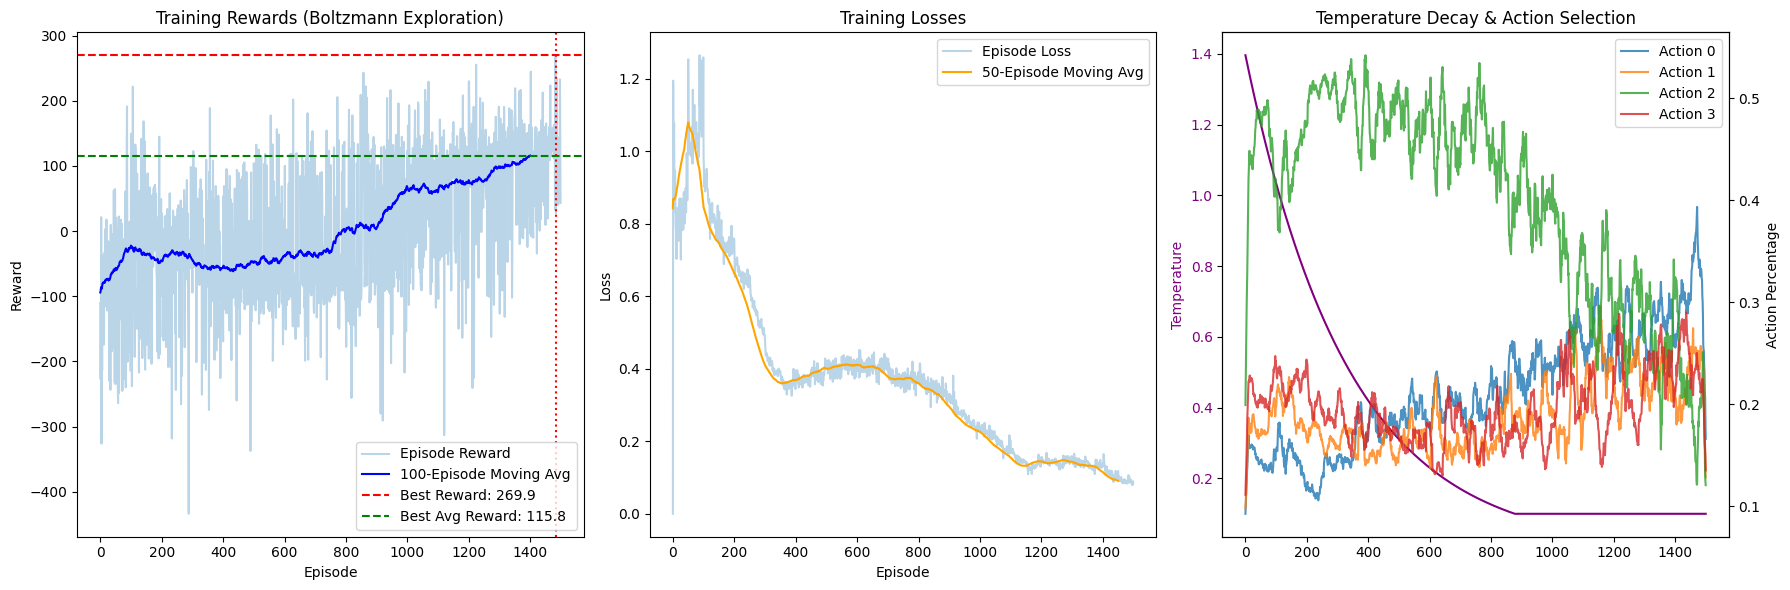

In [332]:
if __name__ == "__main__":
    trainer = BoltDQNTrainer()
    trainer.train()

# IV - Results



- Show the experimental outputs to show the impact of experience replay 
- Visualize the results and explain outputs
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.
    - Hint: example visualization can be the reward/return curve, win/lose plot, score plot, etc.
    -       Feel free to try new plots if you want.
    
- DISCUSS the impact of ER and Exploration that you chose. 

# V. Conclusions

Discuss the challenges or somethat that you learned.
If you have any suggestion about the assignment, you can write about it.

# Extra Credit (maximum 2 possible credits)

## Soft Actor-Critic (SAC) 

Off-policy soft actor-critic is one of SOTA algorithms, which encourage exploration through entropy regularization. After implementing SAC, you can play with the temperature parameter to adjust the exploration and exploitation balance. 


SOFT ACTOR-CRITIC MODEL HYPERPARAMETERS

In [ ]:
# SAC Model Hyperparameters
AHP = {
    'hidden_dim': 128,
    'gamma': 0.99,
    'tau': 2e-3,
    'alpha': None,  # Use auto entropy tuning
    'learning_rate': 5e-5,

    # Replay Buffer
    'buffer_size': 100000,
    'batch_size': 16,

    # Training Process
    'num_episodes': 2000,
    'max_steps': 700,
    'updates_per_step': 35,
    'warmup_steps': 6000,
    'eval_freq': 50,
    'render_eval_episodes': 5,

    # Optimization
    'target_update_interval': 75,
    'grad_clip': 2,

    # Normalization
    'obs_norm_eps': 1e-8,

    # Monitoring
    'q_value_log_freq': 100,
    'reference_state': [0, 0, 0, 0, 0, 0, 0, 0]
}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SOFT ACTOR-CRITIC MODEL PRIORITIZED EXPERIENCE REPLAY (PER) BUFFER

In [234]:
class PrioritizedReplayBuffer:
    def __init__(self, alpha=0.7):
        self.capacity = AHP['buffer_size']
        self.buffer = []
        self.priorities = []
        self.alpha = alpha
        self.pos = 0

    def push(self, state, action, reward, next_state, done):
        max_priority = max(self.priorities, default=1.0)
        transition = (state, action, reward, next_state, done)
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
            self.priorities.append(max_priority)
        else:
            self.buffer[self.pos] = transition
            self.priorities[self.pos] = max_priority
            self.pos = (self.pos + 1) % self.capacity

    def sample(self, beta=0.5):
        priorities = np.array(self.priorities)
        probs = priorities ** self.alpha
        probs /= probs.sum()
        indices = np.random.choice(len(self.buffer), AHP['batch_size'], p=probs)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = torch.FloatTensor(weights).to(DEVICE).unsqueeze(1)

        states, actions, rewards, next_states, dones = map(np.array, zip(*samples))
        return (
            torch.FloatTensor(states).to(DEVICE),
            torch.LongTensor(actions).to(DEVICE).unsqueeze(1),
            torch.FloatTensor(rewards).to(DEVICE).unsqueeze(1),
            torch.FloatTensor(next_states).to(DEVICE),
            torch.FloatTensor(dones).to(DEVICE).unsqueeze(1),
            torch.LongTensor(indices),
            weights
        )

    def update_priorities(self, indices, td_errors):
        td_errors = td_errors.squeeze().detach().cpu().numpy()
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = float(abs(td_error) + 1e-6)


    def __len__(self):
        return len(self.buffer)


SOFT ACTOR-CRITIC MODEL Q-NETWORK

In [235]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, AHP['hidden_dim']),
            nn.ReLU(),
            nn.LayerNorm(AHP['hidden_dim']),
            nn.Linear(AHP['hidden_dim'], AHP['hidden_dim']),
            nn.ReLU(),
            nn.Linear(AHP['hidden_dim'], action_dim)
        )
    def forward(self, state):
        return self.net(state)

SOFT ACTOR-CRITIC MODEL POLICY NETWORK

In [236]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, AHP['hidden_dim']),
            nn.ReLU(),
            nn.LayerNorm(AHP['hidden_dim']),
            nn.Linear(AHP['hidden_dim'], AHP['hidden_dim']),
            nn.ReLU()
        )
        self.head = nn.Linear(AHP['hidden_dim'], action_dim)

    def forward(self, state):
        x = self.shared(state)
        logits = self.head(x)
        probs = F.softmax(logits, dim=-1)
        log_probs = F.log_softmax(logits, dim=-1)
        return probs, log_probs

    def sample(self, state):
        probs, log_probs = self.forward(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action, log_probs.gather(1, action.unsqueeze(1))


SOFT ACTOR-CRITIC MODEL DISCRETE AGENT + TRAINER

In [ ]:
class DiscreteSAC:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.total_steps = 0

        self.q1 = QNetwork(state_dim, action_dim).to(DEVICE)
        self.q2 = QNetwork(state_dim, action_dim).to(DEVICE)
        self.q1_target = QNetwork(state_dim, action_dim).to(DEVICE)
        self.q2_target = QNetwork(state_dim, action_dim).to(DEVICE)
        self.policy = PolicyNetwork(state_dim, action_dim).to(DEVICE)

        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())

        self.q1_optimizer = torch.optim.Adam(self.q1.parameters(), lr=AHP['learning_rate'])
        self.q2_optimizer = torch.optim.Adam(self.q2.parameters(), lr=AHP['learning_rate'])
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=AHP['learning_rate'])

        self.memory = PrioritizedReplayBuffer()
        self.obs_mean = torch.zeros(state_dim, device=DEVICE)
        self.obs_std = torch.ones(state_dim, device=DEVICE)

        self.log_alpha = torch.tensor(np.log(0.3), requires_grad=True, device=DEVICE)
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=AHP['learning_rate'])
        self.target_entropy = -np.log(1.0 / self.action_dim) * 0.98
        self.td_loss_history = []
        self.episode_rewards = []
        self.temperature_history = []
        self.best_reward = -float('inf')
        self.action_distributions = []
        self.gradient_norms = []

    def normalize_obs(self, state):
        state = torch.FloatTensor(state).to(DEVICE)
        self.obs_mean = 0.999 * self.obs_mean + 0.001 * state
        self.obs_std = 0.999 * self.obs_std + 0.001 * (state - self.obs_mean).abs()
        return (state - self.obs_mean) / (self.obs_std + AHP['obs_norm_eps'])

    def act(self, state, eval_mode=False):
        if len(self.memory) < AHP['warmup_steps'] and not eval_mode:
            return random.randint(0, self.action_dim - 1)
        state = self.normalize_obs(state).unsqueeze(0)
        with torch.no_grad():
            if eval_mode:
                probs, _ = self.policy(state)
                return torch.argmax(probs).item()
            else:
                action, _ = self.policy.sample(state)
                return action.item()

    def update(self):
        if len(self.memory) < AHP['batch_size']:
            return
        state, action, reward, next_state, done, indices, weights = self.memory.sample()

        with torch.no_grad():
            next_probs, next_log_probs = self.policy(next_state)
            q1_next = self.q1_target(next_state)
            q2_next = self.q2_target(next_state)
            min_q_next = torch.min(q1_next, q2_next)
            next_value = (next_probs * (min_q_next - self.log_alpha.exp() * next_log_probs)).sum(dim=1, keepdim=True)
            q_target = reward + (1 - done) * AHP['gamma'] * next_value

        q1_pred = self.q1(state).gather(1, action)
        q2_pred = self.q2(state).gather(1, action)
        td_error = q1_pred - q_target

        q1_loss = (weights * F.smooth_l1_loss(q1_pred, q_target, reduction='none')).mean()
        q2_loss = (weights * F.smooth_l1_loss(q2_pred, q_target, reduction='none')).mean()

        self.q1_optimizer.zero_grad()
        q1_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q1.parameters(), AHP['grad_clip'])
        self.q1_optimizer.step()

        self.q2_optimizer.zero_grad()
        q2_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q2.parameters(), AHP['grad_clip'])
        self.q2_optimizer.step()

        self.memory.update_priorities(indices, td_error)

        probs, log_probs = self.policy(state)
        with torch.no_grad():
            min_q = torch.min(self.q1(state), self.q2(state))
        policy_loss = (probs * (self.log_alpha.exp() * log_probs - min_q)).sum(dim=1).mean()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), AHP['grad_clip'])
        self.policy_optimizer.step()

        alpha_loss = -(self.log_alpha * (log_probs + self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        torch.nn.utils.clip_grad_norm_([self.log_alpha], 4.0)
        self.alpha_optimizer.step()

        for t_param, param in zip(self.q1_target.parameters(), self.q1.parameters()):
            t_param.data.copy_(AHP['tau'] * param.data + (1 - AHP['tau']) * t_param.data)
        for t_param, param in zip(self.q2_target.parameters(), self.q2.parameters()):
            t_param.data.copy_(AHP['tau'] * param.data + (1 - AHP['tau']) * t_param.data)

        self.td_loss_history.append((q1_loss.item() + q2_loss.item()) / 2)

    def train(self, env):
        for episode in range(1, AHP['num_episodes'] + 1):
            state, _ = env.reset()
            episode_reward = 0
            done = False
            action_counts = np.zeros(self.action_dim)

            for _ in range(AHP['max_steps']):
                self.total_steps += 1
                action = self.act(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                self.memory.push(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                action_counts[action] += 1
                self.update()
                if done:
                    break

            self.episode_rewards.append(episode_reward)
            self.action_distributions.append(action_counts)
            self.temperature_history.append(self.log_alpha.exp().item())
            self.best_reward = max(self.best_reward, episode_reward)

            avg_reward = np.mean(self.episode_rewards[-100:]) if len(self.episode_rewards) >= 100 else np.mean(self.episode_rewards)
            current_loss = np.mean(self.td_loss_history[-10:]) if self.td_loss_history else 0

            print(f"Episode {episode:4d} | Reward: {episode_reward:7.1f} (Best: {self.best_reward:7.1f}) | "
                  f"Avg100: {avg_reward:7.1f} | Alpha: {self.log_alpha.exp().item():.4f} | "
                  f"Loss: {current_loss:.3f} | Actions: {'/'.join(f'{int(c):2d}' for c in action_counts)}")

            if episode % AHP['eval_freq'] == 0:
                eval_reward = self.evaluate(env, n_episodes=5)
                if eval_reward > self.best_reward:
                    self.best_reward = eval_reward
                    torch.save(self.policy.state_dict(), 'sac_policy.pth')
                with torch.no_grad():
                    ref = torch.FloatTensor(AHP['reference_state']).unsqueeze(0).to(DEVICE)
                    q_vals = self.q1(ref).cpu().numpy().squeeze()
                    print(f"Q1 values: min={q_vals.min():6.2f} max={q_vals.max():6.2f} mean={q_vals.mean():6.2f}")

        print("\nTraining complete!")
        final_env = gym.make('LunarLander-v3', render_mode='human')
        final_reward = self.evaluate(final_env, AHP['render_eval_episodes'], render=True)
        final_env.close()
        print(f"Final evaluation reward: {final_reward:.1f}")
        self.plot_training_results()

    def evaluate(self, env, n_episodes=5, render=False):
        rewards = []
        for _ in range(n_episodes):
            state, _ = env.reset()
            done, total_reward = False, 0
            while not done:
                if render:
                    env.render()
                action = self.act(state, eval_mode=True)
                state, reward, terminated, truncated, _ = env.step(action)
                total_reward += reward
                done = terminated or truncated
            rewards.append(total_reward)
        return np.mean(rewards)

    def plot_training_results(self):
        if not self.episode_rewards:
            print("No data to plot.")
            return

        episodes = np.arange(len(self.episode_rewards))
        avg_window = 100
        loss_window = 50

        reward_smooth = np.convolve(self.episode_rewards, np.ones(avg_window)/avg_window, mode='valid')
        loss_smooth = np.convolve(self.td_loss_history, np.ones(loss_window)/loss_window, mode='valid') \
                      if len(self.td_loss_history) >= loss_window else self.td_loss_history

        best_reward = np.max(self.episode_rewards)
        best_avg_reward = np.max(reward_smooth)

        action_distributions = np.array(self.action_distributions)
        action_percents = action_distributions / np.clip(action_distributions.sum(axis=1, keepdims=True), 1e-8, None)

        fig, axs = plt.subplots(1, 3, figsize=(18, 5), facecolor='white')

        axs[0].plot(episodes, self.episode_rewards, color='skyblue', alpha=0.3, label='Episode Reward')
        axs[0].plot(episodes[avg_window-1:], reward_smooth, color='blue', linewidth=2, label=f'{avg_window}-Episode Moving Avg')
        axs[0].axhline(best_reward, color='red', linestyle='--', label=f'Best Reward: {best_reward:.1f}')
        axs[0].axhline(best_avg_reward, color='green', linestyle='--', label=f'Best Avg Reward: {best_avg_reward:.1f}')
        axs[0].set_title("Training Rewards (Soft Actor-Critic (SAC))")
        axs[0].set_xlabel("Episode")
        axs[0].set_ylabel("Reward")
        axs[0].legend()
        axs[0].grid(alpha=0.3)

        axs[1].plot(self.td_loss_history, color='orange', alpha=0.3, label='TD Loss')
        if isinstance(loss_smooth, np.ndarray):
            axs[1].plot(np.arange(loss_window-1, loss_window-1+len(loss_smooth)), loss_smooth,
                        color='darkorange', linewidth=2, label=f'{loss_window}-Episode Moving Avg')
        axs[1].set_title("Critic Loss (TD Error)")
        axs[1].set_xlabel("Episode")
        axs[1].set_ylabel("Loss")
        axs[1].legend()
        axs[1].grid(alpha=0.3)

        ax1 = axs[2]
        ax2 = ax1.twinx()
        smooth_window = 20
        smoothed_action_percents = np.zeros_like(action_percents)
        for i in range(self.action_dim):
            smoothed_action_percents[:, i] = np.convolve(
                action_percents[:, i],
                np.ones(smooth_window) / smooth_window,
                mode='same'
            )
        for i in range(self.action_dim):
            ax2.plot(episodes, smoothed_action_percents[:, i], label=f'Action {i}')
        ax1.plot(episodes, self.temperature_history, color='purple', linewidth=2, label='Alpha')
        ax1.set_ylabel("Alpha (log_alpha.exp())", color='purple')
        ax2.set_ylabel("Action Percentage")
        ax1.set_xlabel("Episode")
        ax1.set_title("Alpha & Action Distribution")
        ax2.legend(loc='upper right')
        ax1.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


MAIN IMPLEMENTATION OF SOFT ACTOR-CRITIC MODEL

Episode    1 | Reward:  -249.1 (Best:  -249.1) | Avg100:  -249.1 | Alpha: 0.2981 | Loss: 2.221 | Actions: 32/32/30/24
Episode    2 | Reward:  -139.2 (Best:  -139.2) | Avg100:  -194.1 | Alpha: 0.2952 | Loss: 2.133 | Actions: 33/32/17/29
Episode    3 | Reward:  -274.9 (Best:  -139.2) | Avg100:  -221.1 | Alpha: 0.2921 | Loss: 2.268 | Actions: 28/28/27/15
Episode    4 | Reward:  -130.5 (Best:  -130.5) | Avg100:  -198.4 | Alpha: 0.2886 | Loss: 2.589 | Actions: 25/36/35/38
Episode    5 | Reward:  -126.7 (Best:  -126.7) | Avg100:  -184.1 | Alpha: 0.2871 | Loss: 3.422 | Actions: 16/11/12/24
Episode    6 | Reward:   -81.6 (Best:   -81.6) | Avg100:  -167.0 | Alpha: 0.2850 | Loss: 2.305 | Actions: 17/19/26/27
Episode    7 | Reward:  -407.5 (Best:   -81.6) | Avg100:  -201.4 | Alpha: 0.2828 | Loss: 3.229 | Actions: 26/28/27/21
Episode    8 | Reward:  -339.5 (Best:   -81.6) | Avg100:  -218.6 | Alpha: 0.2814 | Loss: 3.559 | Actions: 20/11/18/24
Episode    9 | Reward:  -110.5 (Best:   -81.6) | Avg100:

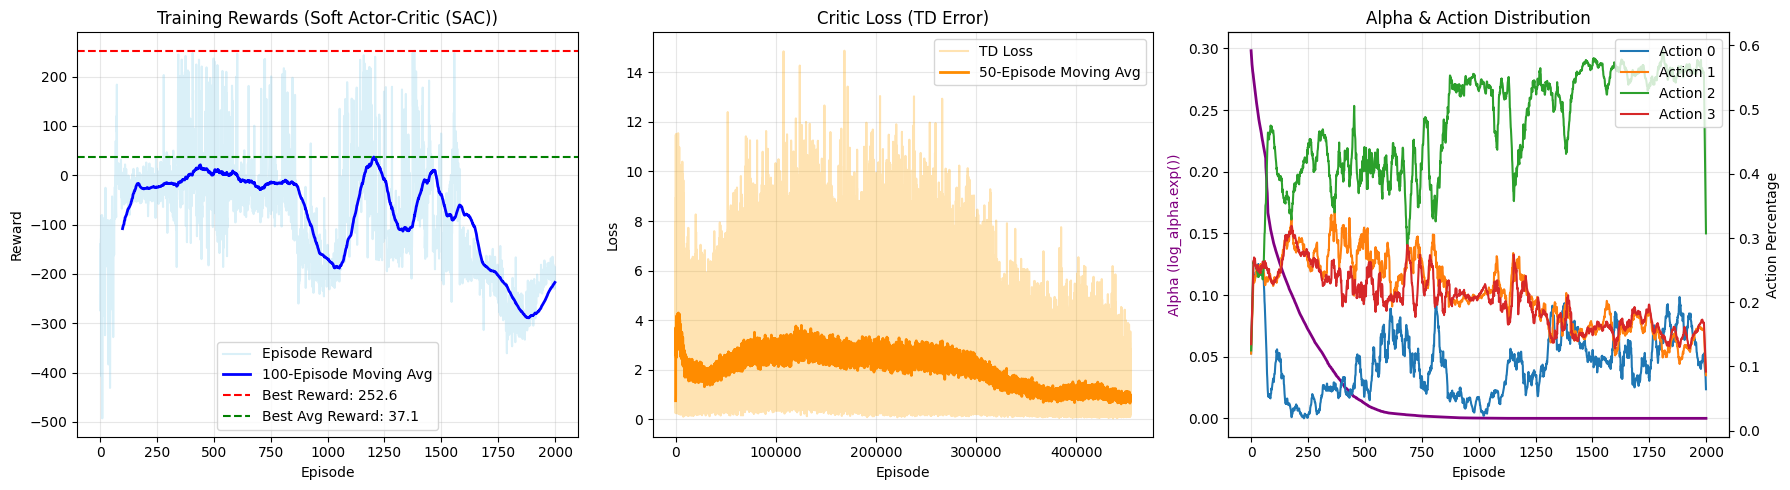

In [238]:
# Main execution
if __name__ == "__main__":
    # Set seeds
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Create and train
    env = gym.make('LunarLander-v3')
    try:
        agent = DiscreteSAC(env.observation_space.shape[0], env.action_space.n)
        agent.train(env)
    finally:
        env.close()

COMMENT ON SAC OUTPUT (FILL IN)

COMPARISON OF PERFORMANCE

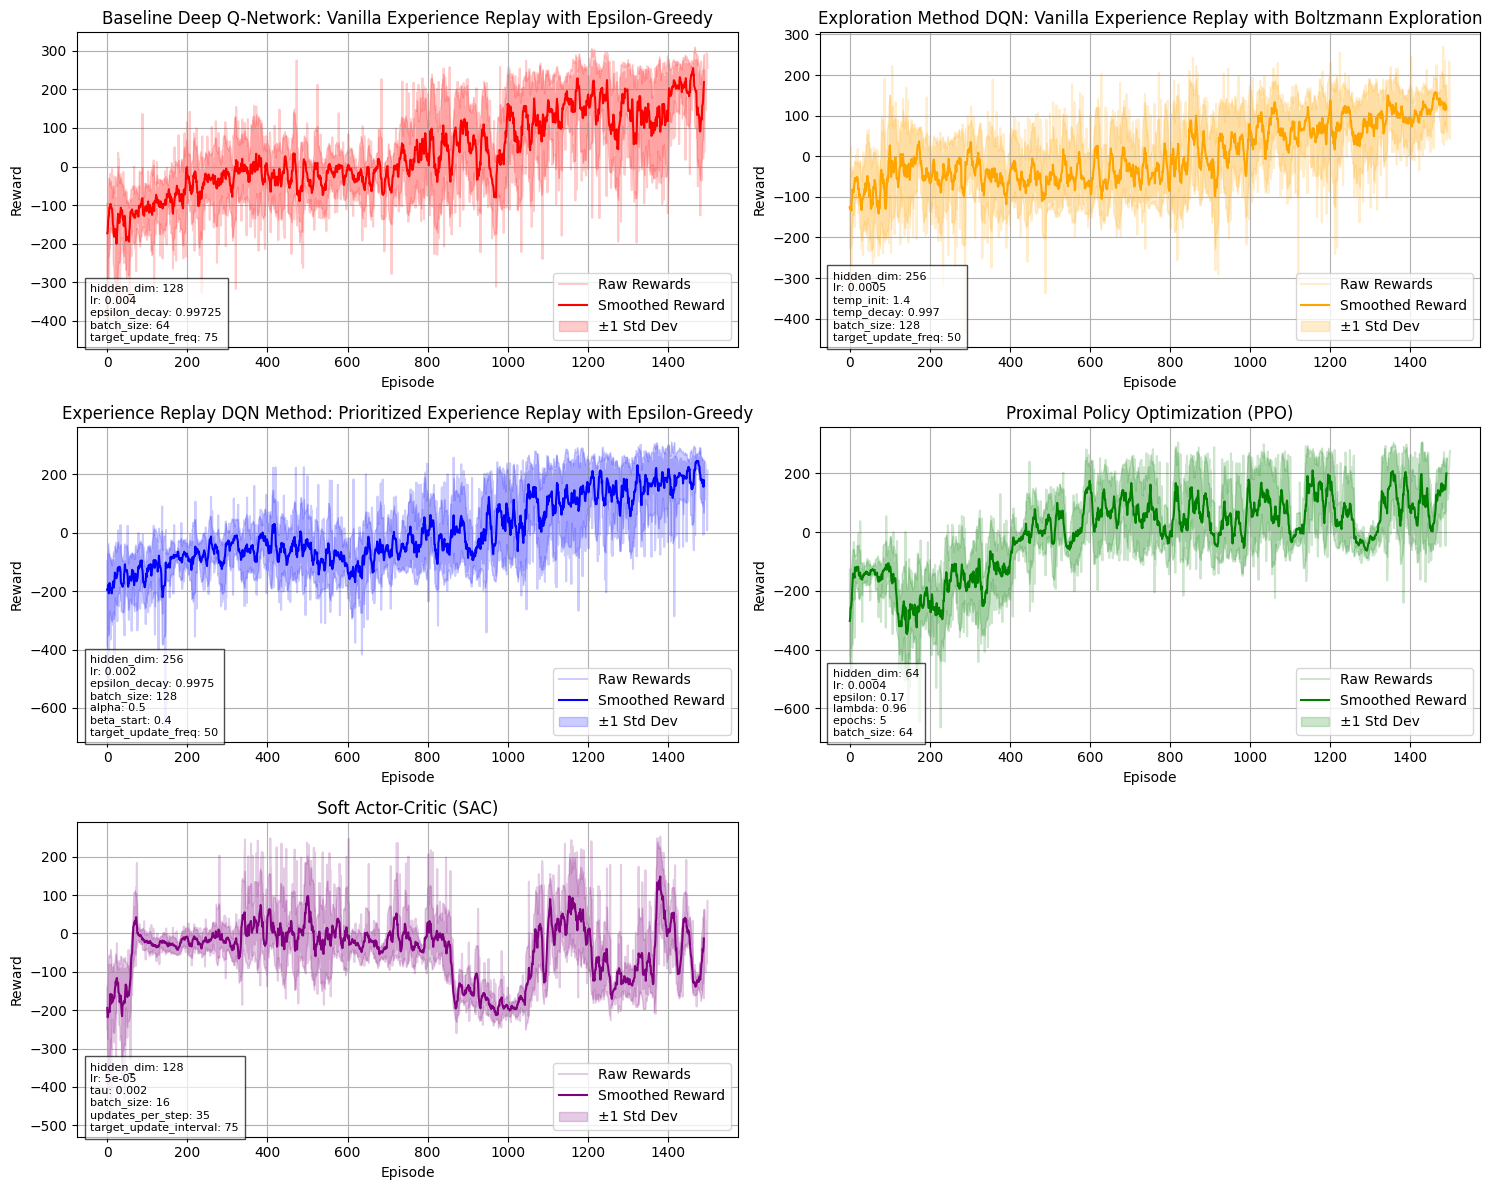

In [11]:
# === Setup path ===
base_path = r"C:\Users\David\OneDrive\Desktop\DSBA 6010 DRL"

# === Utility Functions ===
def extract_rewards(text, pattern=r"Reward:\s+([\-0-9.]+)"):
    return [float(match) for match in re.findall(pattern, text)]

def smooth_with_variance(rewards, window=10):
    rewards = np.array(rewards)
    means = np.convolve(rewards, np.ones(window)/window, mode='valid')
    stds = np.array([np.std(rewards[i:i+window]) for i in range(len(rewards) - window + 1)])
    return means, stds

# === Load Files ===
with open(os.path.join(base_path, "vanilla DQN.txt"), "r") as f: text_dqn = f.read()
with open(os.path.join(base_path, "BOLTZ2.txt"), "r") as f: text_boltz = f.read()
with open(os.path.join(base_path, "PER 2.txt"), "r") as f: text_per = f.read()
with open(os.path.join(base_path, "ppo lander.txt"), "r") as f: text_ppo = f.read()
with open(os.path.join(base_path, "sac lander.txt"), "r") as f: text_sac = f.read()

# === Hyperparameters for each model ===
hyperparams = {
    "Baseline Deep Q-Network: Vanilla Experience Replay with Epsilon-Greedy": {
        "hidden_dim": 128,
        "lr": 0.004,
        "epsilon_decay": 0.99725,
        "batch_size": 64,
        "target_update_freq": 75
    },
    "Exploration Method DQN: Vanilla Experience Replay with Boltzmann Exploration": {
        "hidden_dim": 256,
        "lr": 0.0005,
        "temp_init": 1.4,
        "temp_decay": 0.997,
        "batch_size": 128,
        "target_update_freq": 50
    },
    "Experience Replay DQN Method: Prioritized Experience Replay with Epsilon-Greedy": {
        "hidden_dim": 256,
        "lr": 0.002,
        "epsilon_decay": 0.9975,
        "batch_size": 128,
        "alpha": 0.5,
        "beta_start": 0.4,
        "target_update_freq": 50
    },
    "Proximal Policy Optimization (PPO)": {
        "hidden_dim": 64,
        "lr": 4e-4,
        "epsilon": 0.17,
        "lambda": 0.96,
        "epochs": 5,
        "batch_size": 64
    },
    "Soft Actor-Critic (SAC)": {
        "hidden_dim": 128,
        "lr": 5e-5,
        "tau": 2e-3,
        "batch_size": 16,
        "updates_per_step": 35,
        "target_update_interval": 75
    }
}

# === Extract Rewards in new order ===
model_data = {
    "Baseline Deep Q-Network: Vanilla Experience Replay with Epsilon-Greedy": (extract_rewards(text_dqn), "red"),
    "Exploration Method DQN: Vanilla Experience Replay with Boltzmann Exploration": (extract_rewards(text_boltz), "orange"),
    "Experience Replay DQN Method: Prioritized Experience Replay with Epsilon-Greedy": (extract_rewards(text_per), "blue"),
    "Proximal Policy Optimization (PPO)": (extract_rewards(text_ppo), "green"),
    "Soft Actor-Critic (SAC)": (extract_rewards(text_sac), "purple")
}

# === Plot All Models in Subplots ===
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axes = axes.flatten()

for i, (label, (rewards, color)) in enumerate(model_data.items()):
    mean, std = smooth_with_variance(rewards)
    x = np.arange(len(mean))
    ax = axes[i]

    ax.plot(rewards, color=color, alpha=0.2, label="Raw Rewards")
    ax.plot(x, mean, color=color, label="Smoothed Reward")
    ax.fill_between(x, mean - std, mean + std, color=color, alpha=0.2, label="±1 Std Dev")

    ax.set_title(label)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.legend()
    ax.grid(True)
    
    # Add hyperparameters as text
    param_text = "\n".join([f"{k}: {v}" for k, v in hyperparams[label].items()])
    ax.text(0.02, 0.02, param_text, transform=ax.transAxes, 
            bbox=dict(facecolor='white', alpha=0.7), fontsize=8)

# Hide any unused subplot
for j in range(len(model_data), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Overview of Model Performance

- Most stable = Baseline DQN Model with Vanilla Experience Replay + Epsilon-Greedy
- Quickest to successful episode = Soft Actor-Critic (SAC) Model with Prioritized Experience Replay
- Best moving average achieved = Experience Replay Method DQN Model with Prioritized Experience Replay + Epsilon-Greedy 
- Slowest to successful episode = Baseline DQN Model with Vanilla Experience Replay + Epsilon-Greedy

#### **Baseline DQN with Vanilla Experience Replay + Epsilon-Greedy (Red)**
The baseline DQN with epsilon-greedy exploration portrays a clear and steady learning progression throughout training. Starting out it's moving reward average was approximately -150, but it steadily improves to averaging roughly +200 rewards by episode 1500. It didnt achieve a successful episode until around 400-500 episodes, and only did so a few times.  Once it hit 800 episodes it started to achieve successfull episodes more consistently and experienced more productive learning from then on until the end of the 1500 episode training period. By the end of training the baseline DQN achieves strong and stable performance, making it one of the most reliable methods I implemented in the Lunar Lander v3 environment.

The hyperparameters used: medium-sized network (128 hidden units), a fairly high learning rate (0.004), and a gradual epsilon decay (0.99725) that seemed to balance exploration and exploitation better than other values I tried for decay. The relatively frequent target network updates (every 75 episodes) helped stabilize the learning process and the replay buffer of 100k was a consistent size I used for all models that used an experience replay (Vanilla and PER).

#### **DQN with Vanilla Experience Replay + Boltzmann Exploration (Yellow)**
In contrast to the epsilon-greedy approach, the Boltzmann exploration variant shows a more gradual improvement trajectory. While it eventually reaches positive rewards, its final performance was averaging around +100 rewards by episode 1500 and wasn't able to achieve the consistency that the baseline DQN model had achieved by using epsilon-greedy instead. The learning curve exhibits higher variance with more pronounced fluctuations, and it takes considerably longer to consistently achieve positive rewards. However, the boltzmann model was able to achieve +200 reward (Positive 200 reward or more is considered a successful episode) way faster than the vanilla DQN and the PER DQN model. So this might be more of a hyperparameter tuning improvement that could be made even though it doesn't achieve a moving average close to +200 rewards, but it has a learning trajectory similar to the other two DQN model variants.

For the Boltzmann implementation I used a much lower learning rate (0.0005) and relied more on temperature-based exploration (initial temperature 1.4, decaying by a factor of 0.997 per episode). The slower decay rate of the temperature parameter icontributes to the extended exploration phase and slower convergence compared to epsilon-greedy.

#### **DQN with Prioritized Experience Replay DQN + Epsilon-Greedy (Blue)**
The Prioritized Experience Replay implementation begins with similar initial negative rewards to the baseline DQN and has a similar learning process but it has a lot tighter of a moving average throughout mid and late parts of training. Most notably, it displays an extended plateau between episodes 200-800 before experiencing an acceleration in performance improvement. Despite this different trajectory, it eventually reaches a final performance that is slightly more favorable than that of the baseline DQN. Once it hit 800 episodes and beyond it had lower variance and a stronger push in performance that makes me think that this was the best performing model out of the bunch. Interestingly enough was one of the few models to have 256 hidden dimensions, as I was mainly trying to experiment with 64 and 128 values for the hyperparameter.

This implementation uses a larger network (256 hidden units) with a still high but slightly lower learning rate (0.002) compared to the baseline DQN. The prioritized replay parameters (alpha=0.5, beta starting at 0.4) control how much emphasis is placed on high TD-error experiences, which appears to create a different learning dynamic with the observed plateau followed by accelerated improvement. You can tell that the agent was using important/more successful past experiences with the prioritized replay than the baseline DQN did with the vanilla experience replay.

#### **Proximal Policy Optimization (PPO) (Green)**
PPO exhibits the most oscillatory behavior of all methods evaluated, with pronounced performance cycles throughout training. Despite this volatility, it eventually converges to good performance similar to the DQN methods. The cyclical pattern likely reflects the policy gradient nature of PPO, where periodic policy updates can temporarily decrease performance before subsequent improvements.

For PPO I used a significantly smaller network (64 hidden units) compared to the other methods, with a smaller learning rate (4e-4). The policy update parameters (epsilon=0.17, lambda=0.96) control the conservative update strategy that is characteristic of PPO. The oscillatory behavior could be related to the multiple epochs (5) of policy updates performed at each iteration, but overall the model is a solid choice and definitely has room for improvement. Also, I should look into mimicking PPO's model structure when I next attempt to work on the hybrid on-policy + off-policy PPO extra credit model.

#### **Soft Actor-Critic (SAC) (Purple)**
The SAC implementation demonstrates the most unstable learning pattern with multiple dramatic shifts in performance. While it makes promising early progress and shows impressive peaks around episodes 1000-1250, it fails to sustain this performance. After episode 1500, SAC experiences a catastrophic collapse, ultimately ending with negative rewards around -200.This definitely is due the temperature parameter not decaying like it was supposed to, and I need to look at how I can improve its mechanism in the DiscreteSAC agent class code. 

For SAC I used a pretty small batch size (16) compared to other methods, which might contribute to its instability. The auto-tuned entropy coefficient (alpha) and very low learning rate (5e-5) portray the agent's attempt to stabilize the learning process, but these seem to be sub-optimal for this environment. Also, the intensive update schedule (35 updates per step) could potentially lead to overfitting on recent experiences. I need to review my auto-tuning of the alpha parameter and look into any other potential improvements I could make to the model structure so that it achieves strong, consistent learning throughout training and not just in the first half of training.

## Comparative Analysis and Hyperparameter Impact

- `**Exploration Method**`:
Exploration method selection proves to be critical, as shown by the noticeable performance gap between epsilon-greedy and Boltzmann exploration implementations of DQN. The epsilon-greedy strategy with a decay rate of 0.99725 outperforms Boltzmann exploration with a temperature decay of 0.997. This suggests that in the Lunar Lander environment, occasional completely random exploration (epsilon-greedy) is more effective than the weighted probabilistic approach of Boltzmann exploration, which may be too conservative in exploring low-value but potentially informative actions. However, more hyperparameter tuning will need to be conducted to get a more clear idea of what method works best in this environment.

- `Experience Replay Method`:
The difference between standard and prioritized experience replay demonstrates how memory utilization affects learning dynamics. The prioritized replay configuration (alpha=0.5, beta_start=0.4) portrays a distinct difference in the learning trajectory with a tighter variance spread and stronger learning ability later in training. This suggests that prioritizing experiences alters the information processing sequence, potentially allowing the agent to focus on fundamental aspects of the task before tackling more nuanced behaviors.

- `Hidden Dimensions`:
Network architecture choices also impact performance. The baseline DQN uses a 128-unit hidden layer, while the prioritized replay variant uses a larger 256-unit network. PPO, despite using a much smaller 64-unit network, eventually achieves comparable performance, suggesting that policy gradient methods may require less representational capacity for this particular task.

- `Learning Rate`:
Learning rate selection shows interesting patterns across algorithms. The best performing methods (baseline DQN and prioritized replay) use relatively high learning rates (0.004 and 0.002 respectively), while the less stable methods use much lower rates (SAC at 5e-5). This counter-intuitive result suggests that for this environment, more aggressive learning rates may help escape local optima more effectively.

- `Update Frequency`:
Update frequency variation appears significant between methods. The baseline DQN updates the target network every 75 episodes, while prioritized replay and Boltzmann DQN update every 50 episodes. SAC's intensive update schedule (35 updates per step) may contribute to its instability through potential overfitting to recent experiences.

